## Unpropagated elements for SARAL satellite

import pandas as pd

file_path = 'C:\\Users\\91701\\Documents\\y2t2\\project\\part a\\satellite_data\\orbital_elements\\unpropagated_elements_SARAL.csv'

df_saral = pd.read_csv(file_path)  
print(df_saral.head())


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'C:\\Users\\91701\\Documents\\y2t2\\project\\part a\\satellite_data\\orbital_elements\\unpropagated_elements_SARAL.csv'

df_saral = pd.read_csv(file_path)
print(df_saral.head())

                   Unnamed: 0  eccentricity  argument of perigee  inclination  \
0  2013-03-10 13:13:33.964320      0.000129             3.342279     1.719596   
1  2013-03-11 22:45:10.058975      0.000130             3.291112     1.719589   
2  2013-03-13 01:34:26.835167      0.000151             3.208097     1.719577   
3  2013-03-14 02:43:30.192095      0.000527             1.514363     1.719552   
4  2013-03-15 18:57:49.375584      0.000076             2.181199     1.719575   

   mean anomaly  Brouwer mean motion  right ascension  
0     -3.340260             0.062543         4.532454  
1     -3.289068             0.062543         4.556435  
2     -3.206336             0.062543         4.575627  
3     -1.510258             0.062525         4.593694  
4     -2.179016             0.062531         4.622396  


In [254]:
import pandas as pd
import numpy as np

def convert_timestamp_series_to_epoch(series):
    return (
        (series - pd.Timestamp(year=1970, month=1, day=1)) // pd.Timedelta(seconds=1)
    ).values

def compute_simple_matching_precision_recall_for_one_threshold(
    float_matching_max_days,
    float_threshold,
    pd_series_ground_truth_manoeuvre_timestamps,
    pd_series_predictions
):

    matching_max_distance_seconds = pd.Timedelta(days=float_matching_max_days).total_seconds()

    dict_predictions_to_ground_truth = {}
    dict_ground_truth_to_predictions = {}

    np_manoeuvre_timestamps_seconds = convert_timestamp_series_to_epoch(pd_series_ground_truth_manoeuvre_timestamps)
    np_pred_time_stamps_seconds = convert_timestamp_series_to_epoch(pd_series_predictions.index)
    np_predictions = pd_series_predictions.to_numpy()
    for i in range(np_predictions.shape[0]):
        if np_predictions[i] >= float_threshold:
            left_index = np.searchsorted(
                np_manoeuvre_timestamps_seconds, np_pred_time_stamps_seconds[i]
            )

            if left_index != 0:
                left_index -= 1

            index_of_closest = left_index

            if (left_index < pd_series_ground_truth_manoeuvre_timestamps.shape[0] - 1) and (
                abs(np_manoeuvre_timestamps_seconds[left_index] - np_pred_time_stamps_seconds[i])
                > abs(np_manoeuvre_timestamps_seconds[left_index + 1] - np_pred_time_stamps_seconds[i])
            ):
                index_of_closest = left_index + 1

            diff = abs(np_manoeuvre_timestamps_seconds[index_of_closest] - np_pred_time_stamps_seconds[i])

            if diff < matching_max_distance_seconds:
                dict_predictions_to_ground_truth[i] = (
                    index_of_closest,
                    diff,
                )
                if index_of_closest in dict_ground_truth_to_predictions:
                    dict_ground_truth_to_predictions[index_of_closest].append(i)
                else:
                    dict_ground_truth_to_predictions[index_of_closest] = [i]

    np_positive_prediction_indices = np.argwhere(np_predictions >= float_threshold)[:, 0]
    list_false_positives = [
        pred_ind for pred_ind in np_positive_prediction_indices if pred_ind not in dict_predictions_to_ground_truth.keys()
    ]
    list_false_negatives = [
        true_ind for true_ind in np.arange(0, len(pd_series_ground_truth_manoeuvre_timestamps))
        if true_ind not in dict_ground_truth_to_predictions.keys()
    ]

    if len(dict_ground_truth_to_predictions) + len(list_false_positives) > 0:
        precision = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_positives))
    else:
        precision = 0.0
    if len(dict_ground_truth_to_predictions) + len(list_false_negatives) > 0:
        recall = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_negatives))
    else:
        recall = 0.0

    return (precision, recall)

In [383]:
def plot_curve(pd_series_ground_truth_manoeuvre_timestamps, pd_series_predictions, float_matching_max_days = 5, float_thresholds = None):
    precision = []
    recall = []
    
    if float_thresholds is None:
        float_thresholds = np.linspace(min(pd_series_predictions), max(pd_series_predictions), 100)
        
    for thr in float_thresholds:
        pre, rec = compute_simple_matching_precision_recall_for_one_threshold(float_matching_max_days, thr, pd_series_ground_truth_manoeuvre_timestamps, pd_series_predictions)
        precision.append(pre)
        recall.append(rec)
    
    f1_scores = 2 * (np.array(precision) * np.array(recall)) / (np.array(precision) + np.array(recall) + 1e-10)

    best_f1_index = np.argmax(f1_scores)
    best_f1_score = f1_scores[best_f1_index]
    best_precision = precision[best_f1_index]
    best_recall = recall[best_f1_index]

    plt.figure(figsize = (6, 6))
    plt.plot(recall, precision)
    plt.plot(best_recall, best_precision, 'bo', label = "Best F1 score")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()
    return best_precision, best_recall, best_f1_score

In [26]:
columns = ['eccentricity', 'argument of perigee', 'inclination', 
           'mean anomaly', 'Brouwer mean motion', 'right ascension']

In [2]:
df_saral.describe()

,eccentricity,argument of perigee,inclination,mean anomaly,Brouwer mean motion,right ascension
count,3290.000000,3290.000000,3290.000000,3290.000000,3290.000000,3290.000000
mean,0.000143,1.555963,1.719883,-1.553658,0.062525,3.144041
std,0.000064,0.667961,0.000082,0.667959,0.000005,1.841612
min,0.000002,0.157865,1.719540,-4.476841,0.062519,0.001806
25%,0.000092,0.997294,1.719854,-2.101972,0.062521,1.504751
50%,0.000156,1.552488,1.719875,-1.549967,0.062522,3.146726
75%,0.000196,2.104095,1.719921,-0.994922,0.062531,4.768291
max,0.000527,4.479761,1.720224,-0.155795,0.062543,6.281307


In [3]:
# Manoeuvre file for SARAL

file_path = 'C:\\Users\\91701\\Documents\\y2t2\\project\\part a\\satellite_data\\manoeuvres\\srlman.txt'


def parse_line(line):
    satellite_id = line[0:5].strip()
    start_year = int(line[6:10].strip())
    start_day = int(line[11:14].strip())
    start_hour = int(line[15:17].strip())
    start_minute = int(line[18:20].strip())
    end_year = int(line[21:25].strip())
    end_day = int(line[26:29].strip())
    end_hour = int(line[30:32].strip())
    end_minute = int(line[33:35].strip())
    maneuver_type = line[36:39].strip()
    maneuver_param = line[40:43].strip()
    number_of_burns = int(line[44:45].strip())
    
    burns = []
    for i in range(number_of_burns):
        k = i * 232
        burn_year = int(line[46+k:50+k].strip())
        burn_day = int(line[51+k:54+k].strip())
        burn_hour = int(line[55+k:57+k].strip())
        burn_minute = int(line[58+k:60+k].strip())
        burn_second = float(line[61+k:67+k].strip())
        boost_duration = float(line[68+k:88+k].strip())
        dv1 = float(line[89+k:109+k].strip())
        dv2 = float(line[110+k:130+k].strip())
        dv3 = float(line[131+k:151+k].strip())
        acc1 = float(line[152+k:172+k].strip())
        acc2 = float(line[173+k:193+k].strip())
        acc3 = float(line[194+k:214+k].strip())
        delta_acc1 = float(line[215+k:235+k].strip())
        delta_acc2 = float(line[236+k:256+k].strip())
        delta_acc3 = float(line[257+k:277+k].strip())
        
        burn_data = {
            'satellite_id': satellite_id,
            'start_year': start_year,
            'start_day': start_day,
            'start_hour': start_hour,
            'start_minute': start_minute,
            'end_year': end_year,
            'end_day': end_day,
            'end_hour': end_hour,
            'end_minute': end_minute,
            'maneuver_type': maneuver_type,
            'maneuver_param': maneuver_param,
            'burn_year': burn_year,
            'burn_day': burn_day,
            'burn_hour': burn_hour,
            'burn_minute': burn_minute,
            'burn_second': burn_second,
            'boost_duration': boost_duration,
            'dv1': dv1,
            'dv2': dv2,
            'dv3': dv3,
            'acc1': acc1,
            'acc2': acc2,
            'acc3': acc3,
            'delta_acc1': delta_acc1,
            'delta_acc2': delta_acc2,
            'delta_acc3': delta_acc3
        }
        burns.append(burn_data)
    return burns

def parse_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.strip():  
                burns = parse_line(line)
                start_date = pd.to_datetime(f'{burns[0]["start_year"]}-01-01') + pd.Timedelta(days=burns[0]["start_day"]-1, hours=burns[0]["start_hour"], minutes=burns[0]["start_minute"])
                end_date = pd.to_datetime(f'{burns[0]["end_year"]}-01-01') + pd.Timedelta(days=burns[0]["end_day"]-1, hours=burns[0]["end_hour"], minutes=burns[0]["end_minute"])
                data.append({'Start Date': start_date, 'End Date': end_date})
    return data

data = parse_file(file_path)

man_saral = pd.DataFrame(data)
print(man_saral.head())


           Start Date            End Date
0 2013-02-27 13:14:00 2013-02-27 13:19:00
1 2013-02-27 14:58:00 2013-02-27 15:04:00
2 2013-03-01 15:51:00 2013-03-01 15:53:00
3 2013-03-02 06:03:00 2013-03-02 06:05:00
4 2013-03-03 02:10:00 2013-03-03 02:12:00


In [5]:
import warnings
warnings.filterwarnings("ignore")
df_saral.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
df_saral['datetime'] = pd.to_datetime(df_saral['datetime'])
df_saral.set_index('datetime', inplace=True)

In [6]:
df_saral

,eccentricity,argument of perigee,inclination,mean anomaly,Brouwer mean motion,right ascension
datetime,,,,,,
2013-03-10 13:13:33.964320,0.000129,3.342279,1.719596,-3.340260,0.062543,4.532454
2013-03-11 22:45:10.058975,0.000130,3.291112,1.719589,-3.289068,0.062543,4.556435
2013-03-13 01:34:26.835167,0.000151,3.208097,1.719577,-3.206336,0.062543,4.575627
2013-03-14 02:43:30.192095,0.000527,1.514363,1.719552,-1.510258,0.062525,4.593694
2013-03-15 18:57:49.375584,0.000076,2.181199,1.719575,-2.179016,0.062531,4.622396
...,...,...,...,...,...,...
2022-09-10 11:47:30.833376,0.000189,0.936139,1.720010,-0.933769,0.062523,1.359184
2022-09-11 12:56:41.592191,0.000185,0.912359,1.720012,-0.910001,0.062523,1.377210
2022-09-12 12:25:15.614976,0.000181,0.885215,1.720012,-0.882870,0.062523,1.394035


In [24]:
#SARAL ARIMA

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")
df_saral = df_saral.apply(pd.to_numeric, errors='coerce')

# Ensure no missing values
df_saral.dropna(inplace=True)

# Function to apply ARIMA
def apply_arima(data):
    best_score = float("inf")
    best_params = None
    model_fit = None
    
    for p in range(1, 4):
        for d in range(0, 3):
            for q in range(0, 3):
                try:
                    model = ARIMA(data, order = (p, d, q))
                    results = model.fit()
                    predictions = results.resid
                    mse = mean_squared_error(data, predictions)
                    if mse < best_score:
                        model_fit = results
                        best_score, best_params = mse, (p, d, q)
                except:
                    continue
                    
    return model_fit, best_params, best_score

In [ ]:
arima_results_saral = {}
for column in df_saral.columns:
    arima_results_saral[column] = apply_arima(df_saral[column])

In [23]:
for column, result in arima_results.items():
    print(f"ARIMA model summary for {column}:")
    print(result[0].summary())
    print("\n")

ARIMA model summary for eccentricity:
                               SARIMAX Results                                
Dep. Variable:           eccentricity   No. Observations:                 3290
Model:                 ARIMA(1, 0, 0)   Log Likelihood               32454.124
Date:                Fri, 22 Nov 2024   AIC                         -64902.249
Time:                        18:15:37   BIC                         -64883.953
Sample:                             0   HQIC                        -64895.699
                               - 3290                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   1.13e-05     12.666      0.000       0.000       0.000
ar.L1          0.9803   7.11e-08   1.38e+07      0.000       0.980       0.980
sigma2      1.

In [28]:
def arima_resid_plot(residuals, start, end, man, column):
    residuals_arima = residuals[(residuals.index >= pd.Timestamp(start)) & (residuals.index < pd.Timestamp(end))]
    man = man[(man['Start Date'] >= pd.Timestamp(start)) &(man['Start Date'] < pd.Timestamp(end))]
    
    plt.figure(figsize=(12, 6))
    plt.plot(residuals_arima, label='Residuals')
    plt.ylabel(column)
    plt.xlabel('Date')
    for start in man['Start Date']:
        plt.axvline(x = start, color = 'black', linestyle = '--')

    legend_handles = [plt.plot([], [], color='black',label='Manoeuvres')[0]]
    plt.legend(handles=legend_handles)
    plt.show()

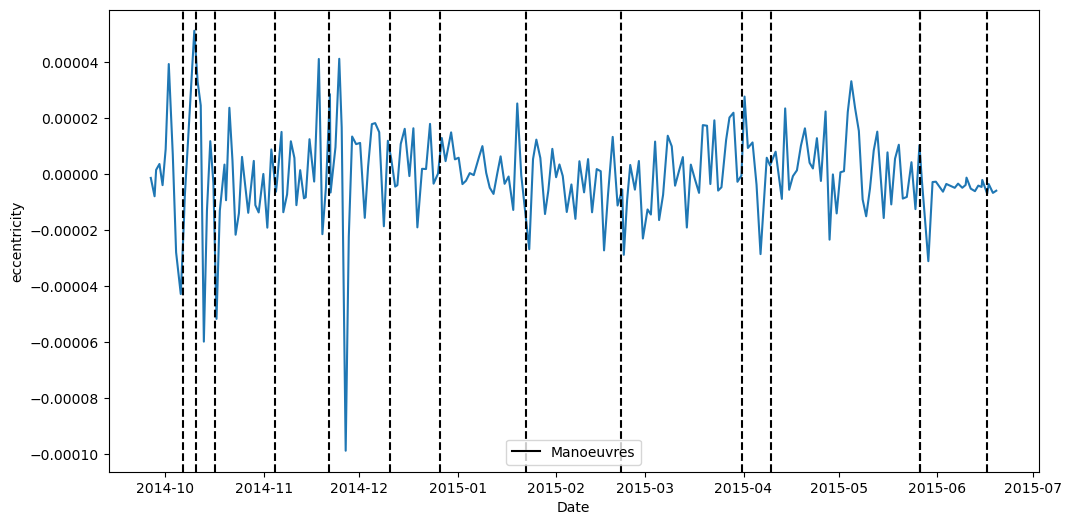

In [33]:
residuals_saral_arima_ecc = arima_results['eccentricity'][0].resid
start =  '2014-09-25'
end = '2015-06-20'

arima_resid_plot(residuals_saral_arima_ecc, start, end, man_saral, 'eccentricity')

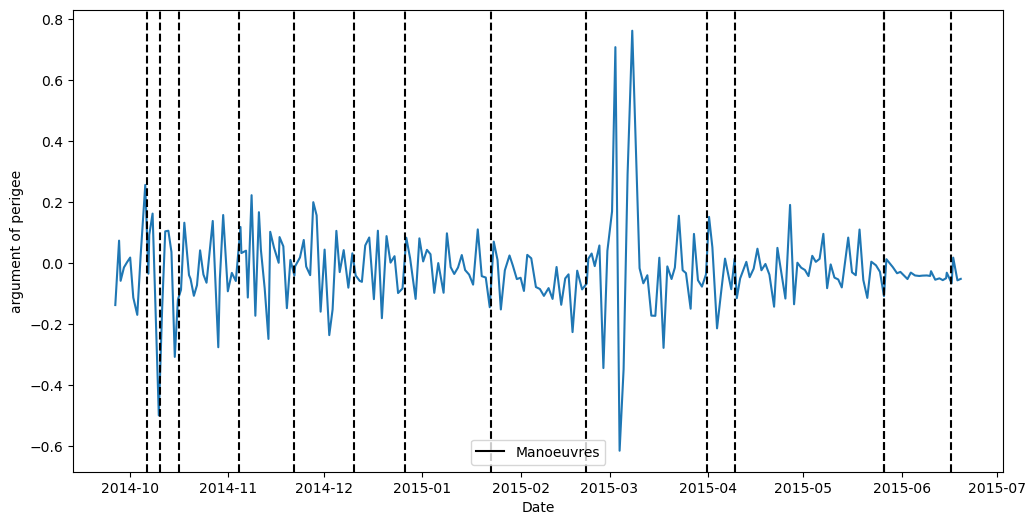

In [34]:
residuals_saral_arima_aop = arima_results['argument of perigee'][0].resid
start =  '2014-09-25'
end = '2015-06-20'

arima_resid_plot(residuals_saral_arima_aop, start, end, man_saral, 'argument of perigee')

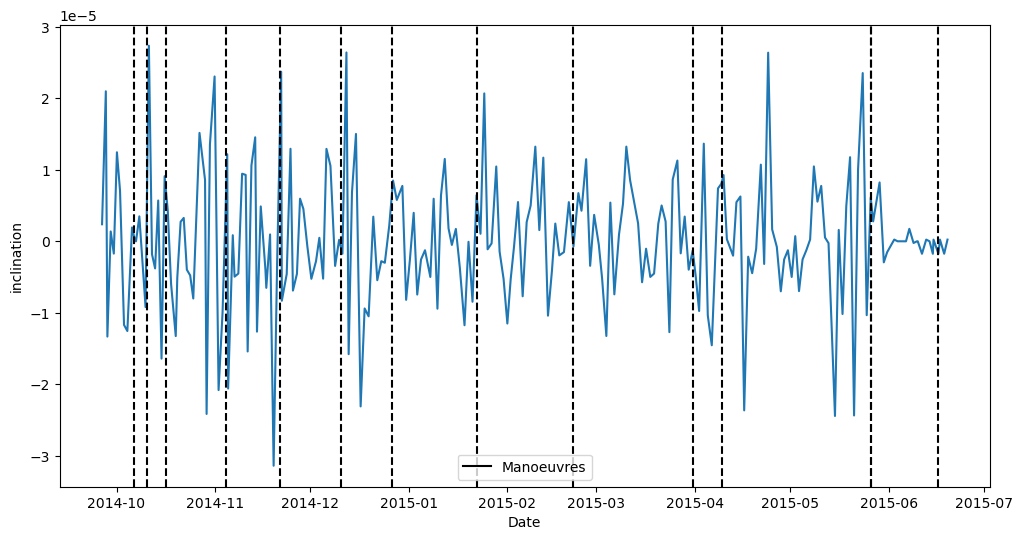

In [35]:
residuals_saral_arima_inc = arima_results['inclination'][0].resid
start =  '2014-09-25'
end = '2015-06-20'

arima_resid_plot(residuals_saral_arima_inc, start, end, man_saral, 'inclination')

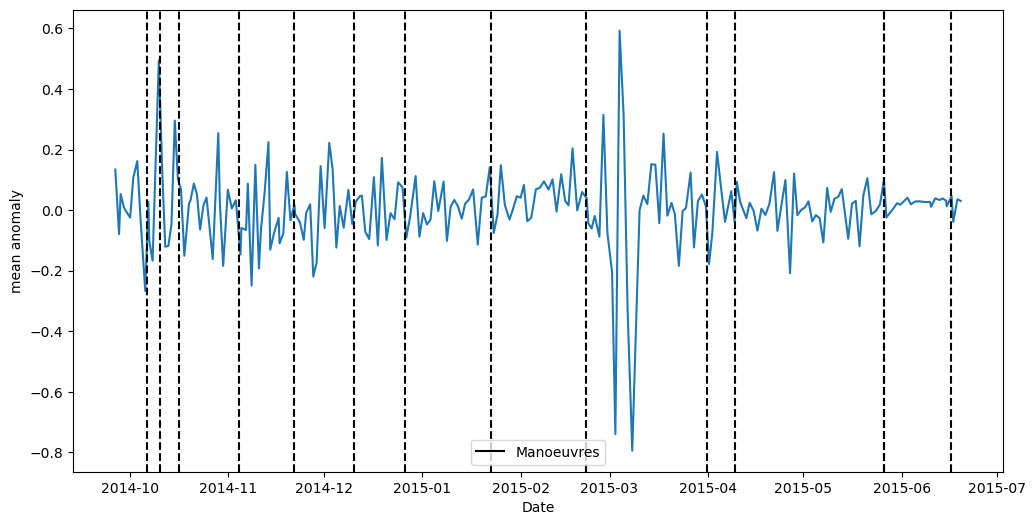

In [36]:
residuals_saral_arima_ma = arima_results['mean anomaly'][0].resid
start =  '2014-09-25'
end = '2015-06-20'

arima_resid_plot(residuals_saral_arima_ma, start, end, man_saral, 'mean anomaly')

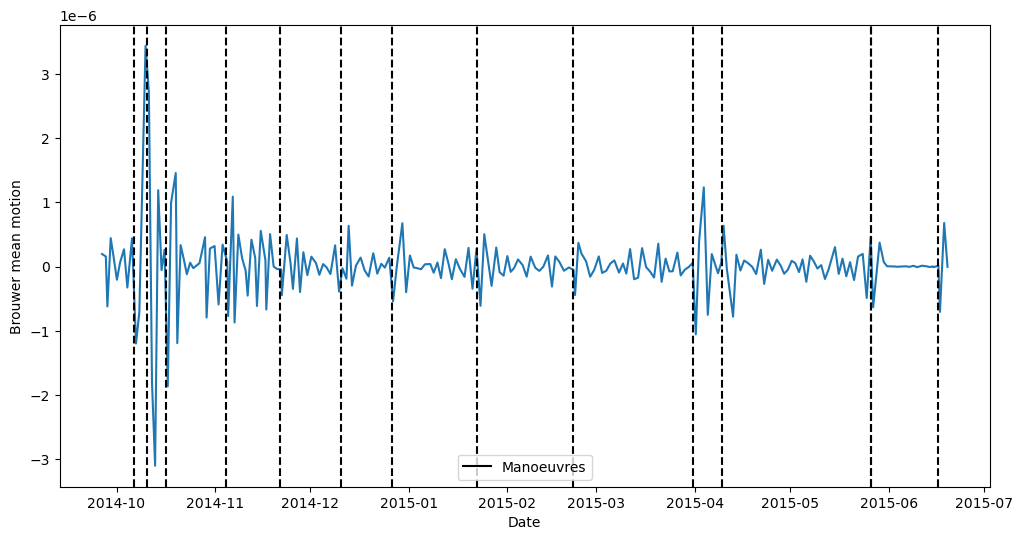

In [37]:
residuals_saral_arima_bmm = arima_results['Brouwer mean motion'][0].resid
start =  '2014-09-25'
end = '2015-06-20'

arima_resid_plot(residuals_saral_arima_bmm, start, end, man_saral, 'Brouwer mean motion')

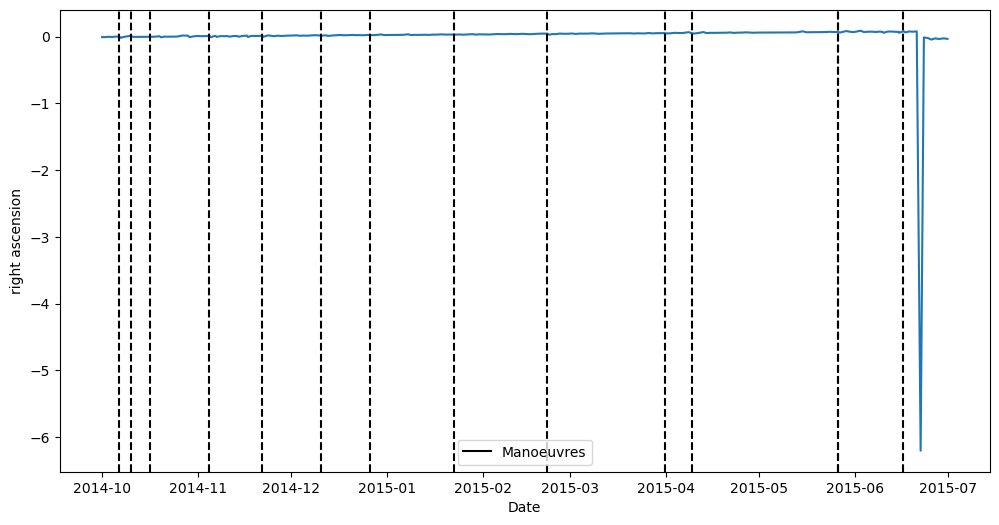

In [38]:
residuals_saral_arima_ra = arima_results['right ascension'][0].resid
start =  '2014-10-01'
end = '2015-07-01'

arima_resid_plot(residuals_saral_arima_ra, start, end, man_saral, 'right ascension')

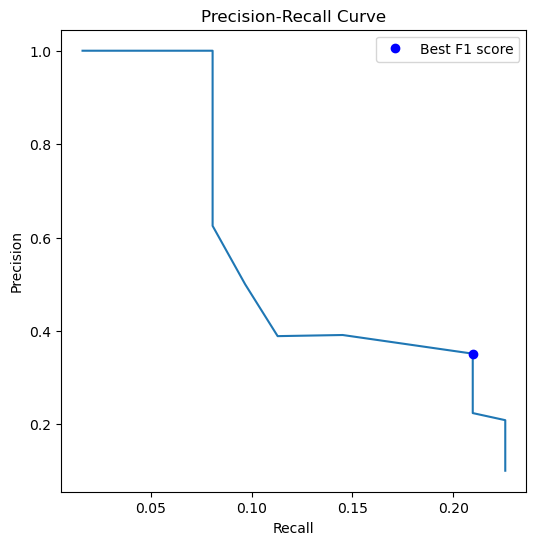

Precision : 0.35135135135135137
Recall : 0.20967741935483872
F1 Score : 0.2626262625794511


In [283]:
best_saral_arima_model = arima_results['Brouwer mean motion'][0]
best_saral_arima_model = best_saral_arima_model.fittedvalues[(best_saral_arima_model.resid.index >= '2014-09-25') & (best_saral_arima_model.resid.index < '2015-06-20'
)]
precision, recall, f1score = plot_curve(man_saral['Start Date'], best_saral_arima_model)

print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1score}")


In [393]:
arima_results['Brouwer mean motion']

(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x2a6275e11c0>,
 (1, 1, 2),
 0.003908134217941326)

In [394]:
s6a_arima_results['Brouwer mean motion']

(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x2a621348430>,
 (3, 1, 2),
 0.003121126853854587)

In [395]:
cs2_arima_results['Brouwer mean motion']

(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x2a62972a310>,
 (2, 1, 2),
 0.004018929589385633)

In [396]:
j3_arima_results['Brouwer mean motion']

(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x2a62d95f580>,
 (2, 1, 2),
 0.003124222855702463)

In [39]:
# Sentinel 6A unpropagated elements

file_path_s6a = 'C:\\Users\\91701\\Documents\\y2t2\\project\\part a\\satellite_data\\orbital_elements\\unpropagated_elements_Sentinel-6A.csv'

df_s6a = pd.read_csv(file_path_s6a)  
print(df_s6a.head())


                   Unnamed: 0  eccentricity  argument of perigee  inclination  \
0  2020-12-05 10:47:44.799647      0.000582             4.521071     1.152715   
1  2020-12-06 03:35:09.704831      0.000583             4.516135     1.152715   
2  2020-12-07 01:58:23.043359      0.000583             4.535687     1.152717   
3  2020-12-08 02:13:32.505312      0.000582             4.518034     1.152711   
4  2020-12-09 08:04:30.230399      0.000582             4.518357     1.152717   

   mean anomaly  Brouwer mean motion  right ascension  
0     -4.520406             0.056154         0.179238  
1     -4.515516             0.056154         0.153622  
2     -4.535093             0.056154         0.119456  
3     -4.517410             0.056154         0.082404  
4     -4.517710             0.056154         0.036849  


In [40]:
df_s6a.describe()

,eccentricity,argument of perigee,inclination,mean anomaly,Brouwer mean motion,right ascension
count,663.000000,663.000000,663.000000,663.000000,663.000000,663.000000
mean,0.000784,4.621659,1.152664,-4.621582,0.055909,3.201560
std,0.000024,0.117674,0.000033,0.117840,0.000024,1.774288
min,0.000575,1.673640,1.152567,-4.879614,0.055904,0.005519
25%,0.000776,4.611174,1.152640,-4.640166,0.055907,1.713881
50%,0.000785,4.627634,1.152663,-4.627447,0.055907,3.216888
75%,0.000795,4.640378,1.152687,-4.611002,0.055907,4.718096
max,0.000910,4.872488,1.152752,-1.670900,0.056154,6.281752


In [41]:
# Manoeuvre file for Sentinel 6a

file_path_man_s6a = 'C:\\Users\\91701\\Documents\\y2t2\\project\\part a\\satellite_data\\manoeuvres\\s6aman.txt'

data = parse_file(file_path_man_s6a)

man_s6a = pd.DataFrame(data)
print(man_s6a)


            Start Date            End Date
0  2020-11-23 02:38:00 2020-11-23 02:38:00
1  2020-11-23 09:50:00 2020-11-23 09:58:00
2  2020-11-24 01:38:00 2020-11-24 01:42:00
3  2020-11-27 05:22:00 2020-11-27 05:25:00
4  2020-12-10 05:01:00 2020-12-10 05:08:00
5  2020-12-14 05:15:00 2020-12-14 05:24:00
6  2020-12-16 06:27:00 2020-12-16 06:28:00
7  2020-12-18 00:38:00 2020-12-18 00:39:00
8  2021-02-18 01:45:00 2021-02-18 01:45:00
9  2021-04-27 07:42:00 2021-04-27 07:50:00
10 2021-04-27 08:10:00 2021-04-27 08:10:00
11 2021-04-29 00:55:00 2021-04-29 00:55:00
12 2021-04-30 10:39:00 2021-04-30 10:39:00
13 2021-08-16 00:21:00 2021-08-16 00:21:00
14 2021-11-25 03:00:00 2021-11-25 03:00:00
15 2022-03-08 03:00:00 2022-03-08 03:00:00
16 2022-06-22 07:30:00 2022-06-22 07:30:00
17 2022-10-13 06:50:00 2022-10-13 06:50:00


In [43]:
warnings.filterwarnings("ignore")
df_s6a.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
df_s6a['datetime'] = pd.to_datetime(df_s6a['datetime'])
df_s6a.set_index('datetime', inplace=True

In [44]:
# Sentinel 6a ARIMA
warnings.filterwarnings("ignore")

df_s6a = df_s6a.apply(pd.to_numeric, errors='coerce')

s6a_arima_results = {}
for column in df_s6a.columns:
    s6a_arima_results[column] = apply_arima(df_s6a[column])

In [45]:
for column, result in s6a_arima_results.items():
    print(f"ARIMA model summary for {column}:")
    print(result[0].summary())
    print("\n")


ARIMA model summary for eccentricity:
                               SARIMAX Results                                
Dep. Variable:           eccentricity   No. Observations:                  663
Model:                 ARIMA(1, 1, 2)   Log Likelihood                6548.026
Date:                Fri, 22 Nov 2024   AIC                         -13088.053
Time:                        19:13:02   BIC                         -13070.072
Sample:                             0   HQIC                        -13081.084
                                - 663                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1851      0.000   -400.465      0.000      -0.186      -0.184
ma.L1         -0.0447      0.000    -94.876      0.000      -0.046      -0.044
ma.L2         

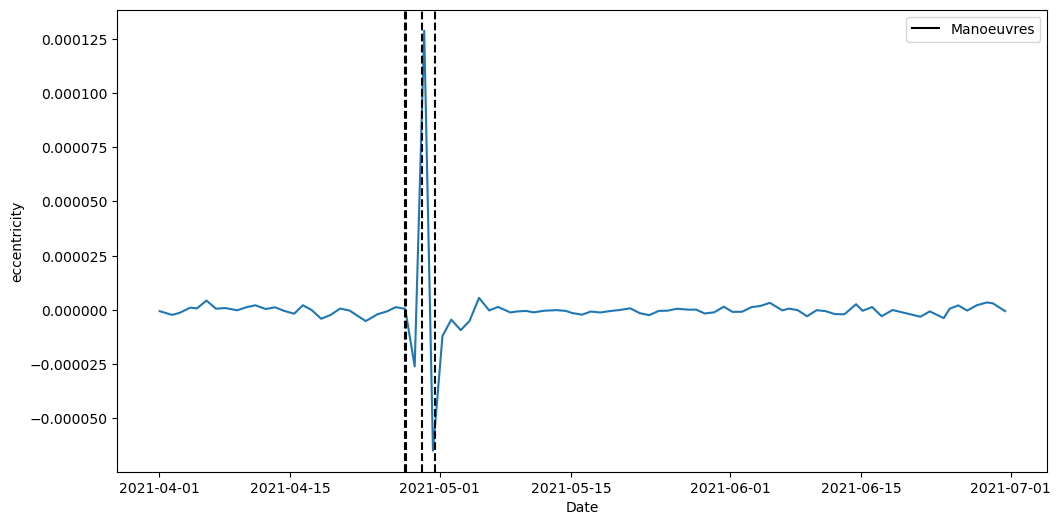

In [47]:
residuals_s6a_arima_ecc = s6a_arima_results['eccentricity'][0].resid
start =  '2021-04-01'
end = '2021-07-01'


arima_resid_plot(residuals_s6a_arima_ecc, start, end, man_s6a, 'eccentricity')

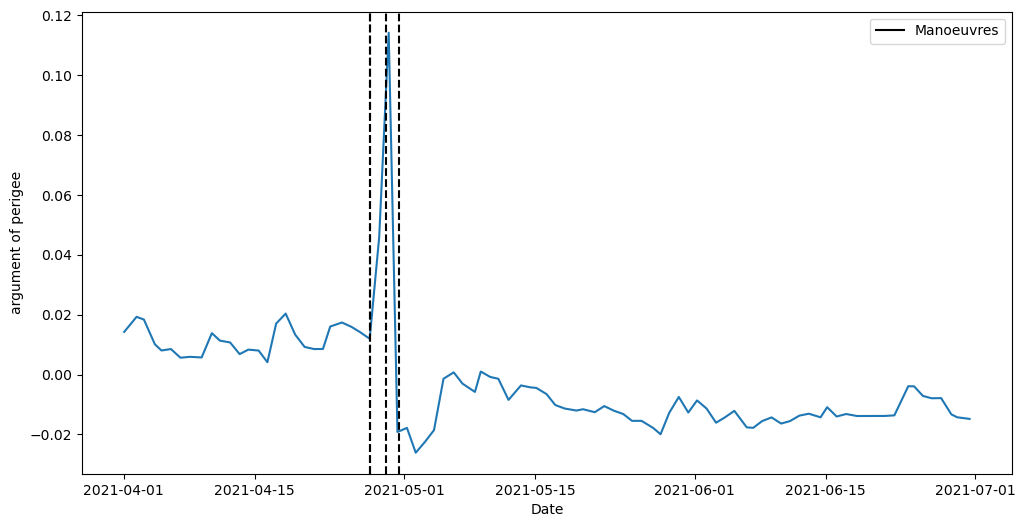

In [48]:
residuals_s6a_arima_aop = s6a_arima_results['argument of perigee'][0].resid
start =  '2021-04-01'
end = '2021-07-01'


arima_resid_plot(residuals_s6a_arima_aop, start, end, man_s6a, 'argument of perigee')

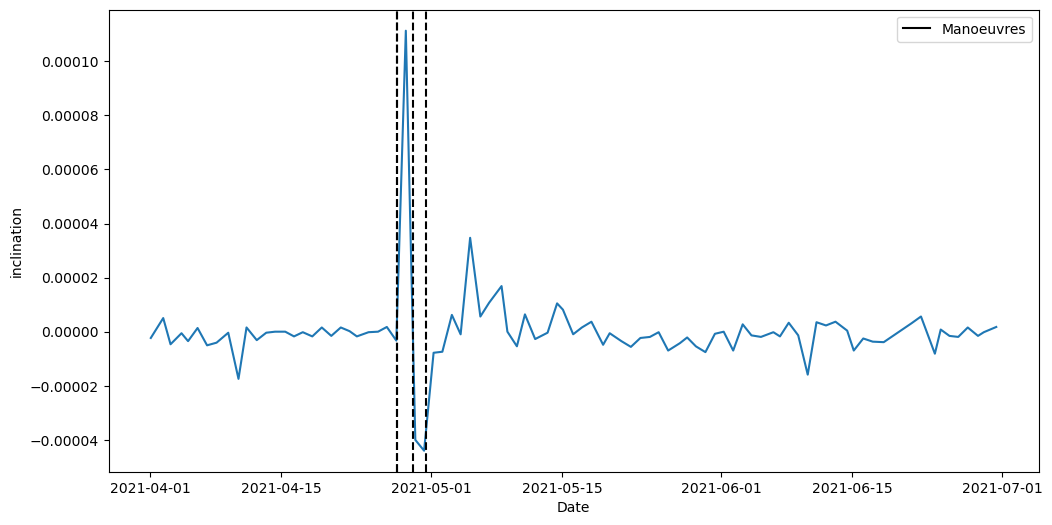

In [49]:
residuals_s6a_arima_inc = s6a_arima_results['inclination'][0].resid
start =  '2021-04-01'
end = '2021-07-01'

arima_resid_plot(residuals_s6a_arima_inc, start, end, man_s6a, 'inclination')

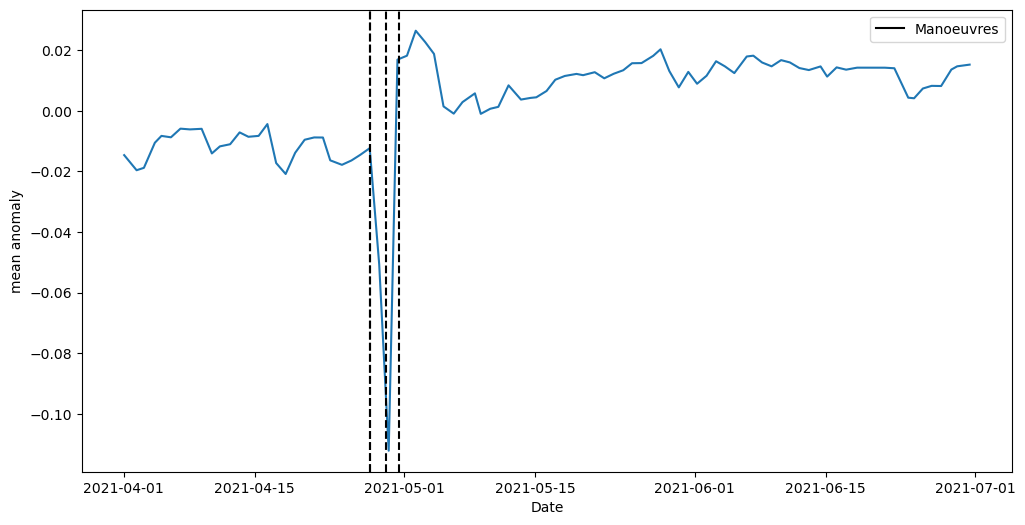

In [50]:
residuals_s6a_arima_ma = s6a_arima_results['mean anomaly'][0].resid
start =  '2021-04-01'
end = '2021-07-01'

arima_resid_plot(residuals_s6a_arima_ma, start, end, man_s6a, 'mean anomaly')

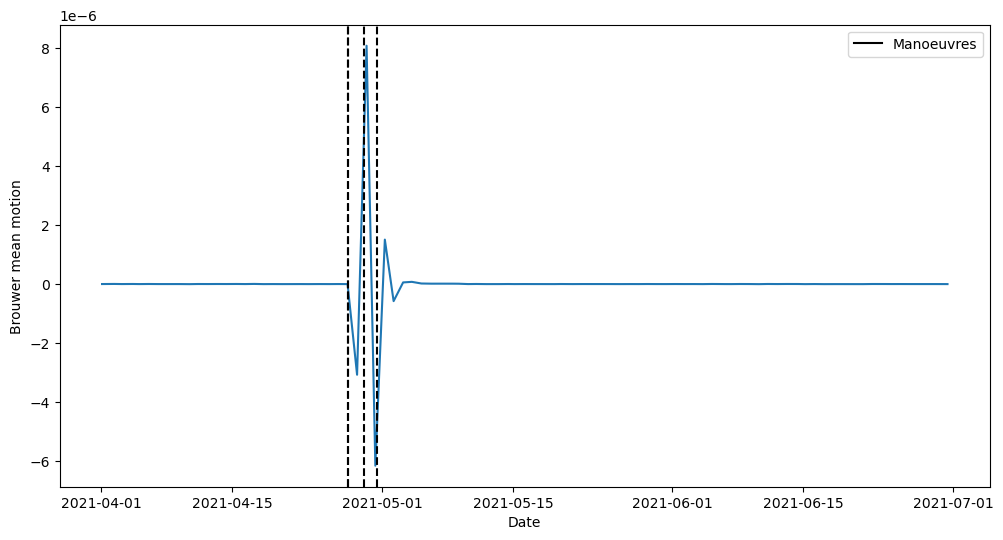

In [51]:
residuals_s6a_arima_bmm = s6a_arima_results['Brouwer mean motion'][0].resid
start =  '2021-04-01'
end = '2021-07-01'

arima_resid_plot(residuals_s6a_arima_bmm, start, end, man_s6a, 'Brouwer mean motion')

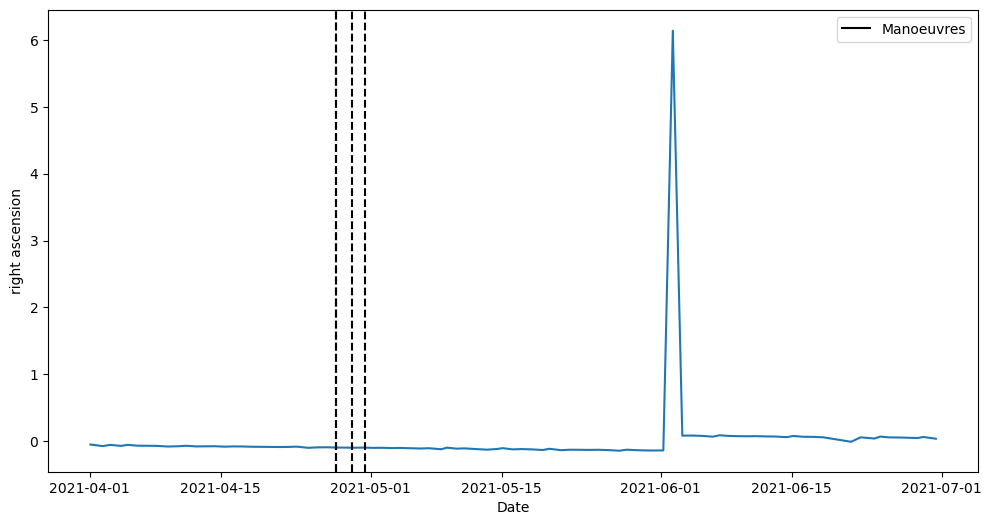

In [52]:
residuals_s6a_arima_ra = s6a_arima_results['right ascension'][0].resid
start =  '2021-04-01'
end = '2021-07-01'

arima_resid_plot(residuals_s6a_arima_ra, start, end, man_s6a, 'right ascension')

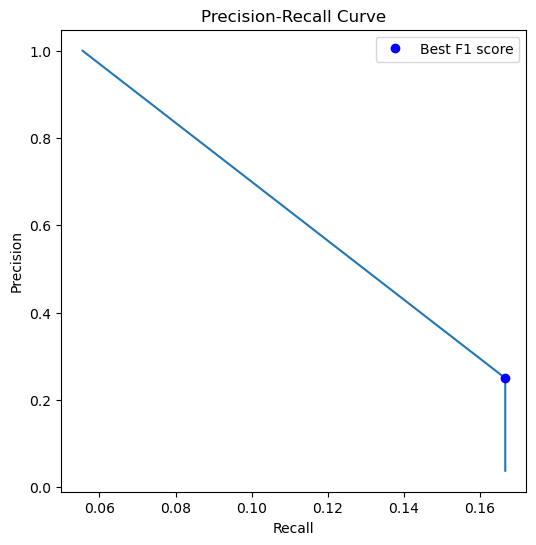

Precision : 0.25
Recall : 0.16666666666666666
F1 Score : 0.199999999952


In [302]:
best_s6a_arima_model = s6a_arima_results['Brouwer mean motion'][0]
best_s6a_arima_model = best_s6a_arima_model.fittedvalues[(best_s6a_arima_model.resid.index >= '2021-04-01') & (best_s6a_arima_model.resid.index < '2021-07-01'
)]
precision, recall, f1score = plot_curve(man_s6a['Start Date'], best_s6a_arima_model)

print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1score}")


In [53]:
# CryoSat 2 unpropogated elements

file_path_cs2 = 'C:\\Users\\91701\\Documents\\y2t2\\project\\part a\\satellite_data\\orbital_elements\\unpropagated_elements_CryoSat-2.csv'

df_cs2 = pd.read_csv(file_path_cs2) 
print(df_cs2.head())


                   Unnamed: 0  eccentricity  argument of perigee  inclination  \
0  2010-04-25 12:13:31.467936      0.001190             3.773156     1.606104   
1  2010-04-26 13:01:57.579456      0.001207             3.697660     1.606110   
2  2010-04-27 22:06:32.422176      0.001224             3.603564     1.606097   
3  2010-04-28 12:59:36.035519      0.001233             3.566036     1.606094   
4  2010-04-29 00:34:12.213407      0.001252             3.529150     1.606097   

   mean anomaly  Brouwer mean motion  right ascension  
0     -3.772437             0.063403         5.077397  
1     -3.696826             0.063403         5.081760  
2     -3.602503             0.063403         5.087575  
3     -3.564917             0.063403         5.090192  
4     -3.527920             0.063403         5.092225  


In [54]:
df_cs2.describe()

,eccentricity,argument of perigee,inclination,mean anomaly,Brouwer mean motion,right ascension
count,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000
mean,0.000823,2.812684,1.606134,-2.818992,0.063402,3.142978
std,0.000233,1.789181,0.000105,1.806961,0.000005,1.816013
min,0.000224,0.003416,1.605876,-6.279445,0.063392,0.001339
25%,0.000650,1.310100,1.606066,-4.303682,0.063404,1.567736
50%,0.000821,2.537463,1.606134,-2.534661,0.063404,3.121135
75%,0.000981,4.249389,1.606216,-1.293878,0.063405,4.756874
max,0.001520,6.281550,1.606350,-0.001040,0.063411,6.281080


In [55]:
# Manoeuvre for CryoSat 2

file_path_man_cs2 = 'C:\\Users\\91701\\Documents\\y2t2\\project\\part a\\satellite_data\\manoeuvres\\cs2man.txt'
data = parse_file(file_path_man_cs2)

man_cs2 = pd.DataFrame(data)
print(man_cs2)


             Start Date            End Date
0   2010-04-15 17:47:00 2010-04-15 17:48:00
1   2010-05-03 17:55:00 2010-05-04 00:35:00
2   2010-05-04 18:38:00 2010-05-04 18:48:00
3   2010-05-05 17:44:00 2010-05-05 17:59:00
4   2010-05-06 18:26:00 2010-05-06 18:51:00
..                  ...                 ...
163 2022-08-03 17:18:00 2022-08-03 17:20:00
164 2022-09-01 17:13:00 2022-09-01 17:14:00
165 2022-09-29 16:20:00 2022-09-29 16:22:00
166 2022-10-02 19:36:00 2022-10-02 19:38:00
167 2022-10-05 19:26:00 2022-10-05 19:29:00

[168 rows x 2 columns]


In [56]:
warnings.filterwarnings("ignore")
df_cs2.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)

df_cs2['datetime'] = pd.to_datetime(df_cs2['datetime'])
df_cs2.set_index('datetime', inplace=True)


In [57]:
warnings.filterwarnings("ignore")
df_cs2 = df_cs2.apply(pd.to_numeric, errors='coerce')

df_cs2.dropna(inplace=True)

cs2_arima_results = {}
for column in df_cs2.columns:
    cs2_arima_results[column] = apply_arima(df_cs2[column])

In [58]:
# Display a summary for each column's ARIMA model
for column, result in cs2_arima_results.items():
    print(f"ARIMA model summary for {column}:")
    print(result[0].summary())
    print("\n")

ARIMA model summary for eccentricity:
                               SARIMAX Results                                
Dep. Variable:           eccentricity   No. Observations:                 4308
Model:                 ARIMA(3, 0, 2)   Log Likelihood               29924.799
Date:                Fri, 22 Nov 2024   AIC                         -59835.598
Time:                        19:26:05   BIC                         -59791.020
Sample:                             0   HQIC                        -59819.856
                               - 4308                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008   3.45e-06    237.425      0.000       0.001       0.001
ar.L1       4.713e-07      0.003      0.000      1.000      -0.006       0.006
ar.L2       4.

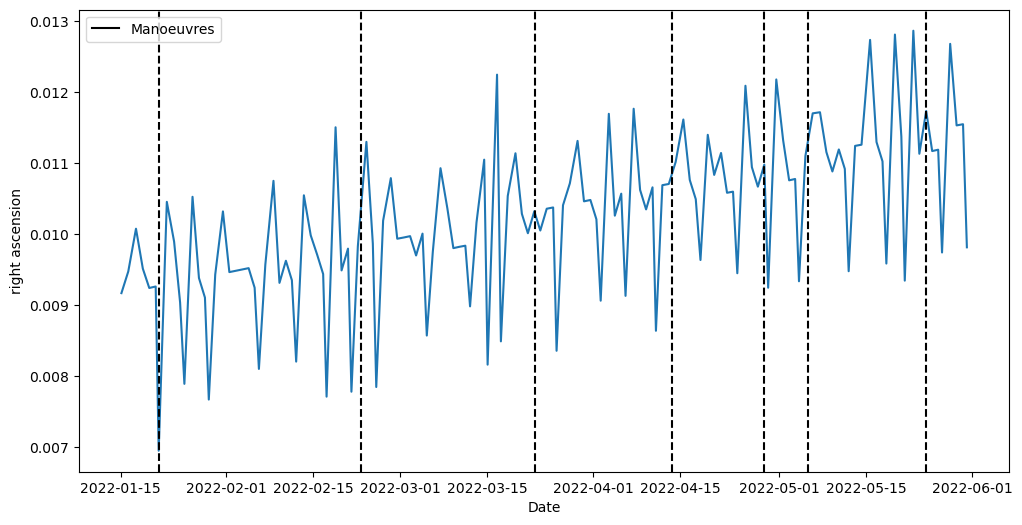

In [60]:
residuals_cs2_arima_ra = cs2_arima_results['right ascension'][0].resid
start =  '2022-01-15'
end = '2022-06-01'

arima_resid_plot(residuals_cs2_arima_ra, start, end, man_cs2, 'right ascension')

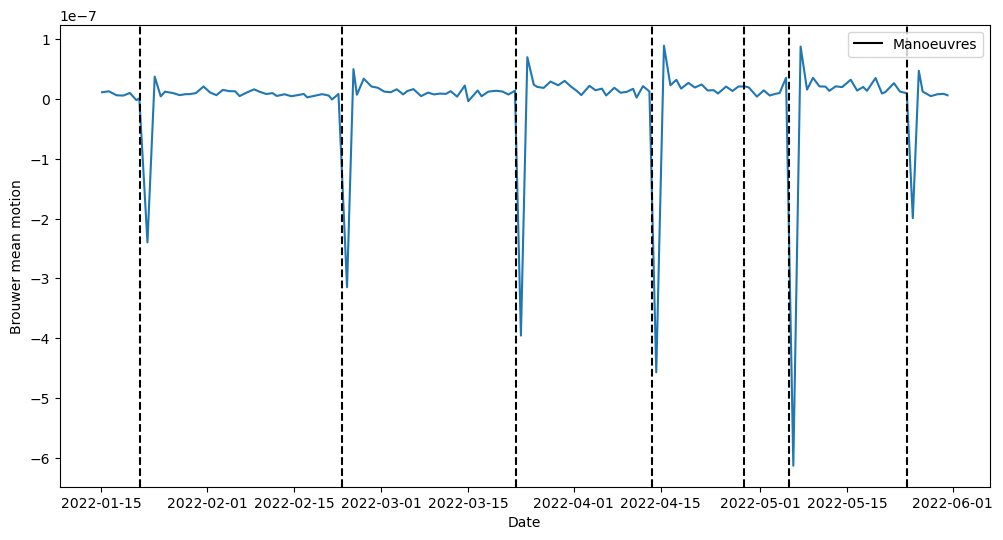

In [61]:
residuals_cs2_arima_bmm = cs2_arima_results['Brouwer mean motion'][0].resid
start =  '2022-01-15'
end = '2022-06-01'

arima_resid_plot(residuals_cs2_arima_bmm, start, end, man_cs2, 'Brouwer mean motion')

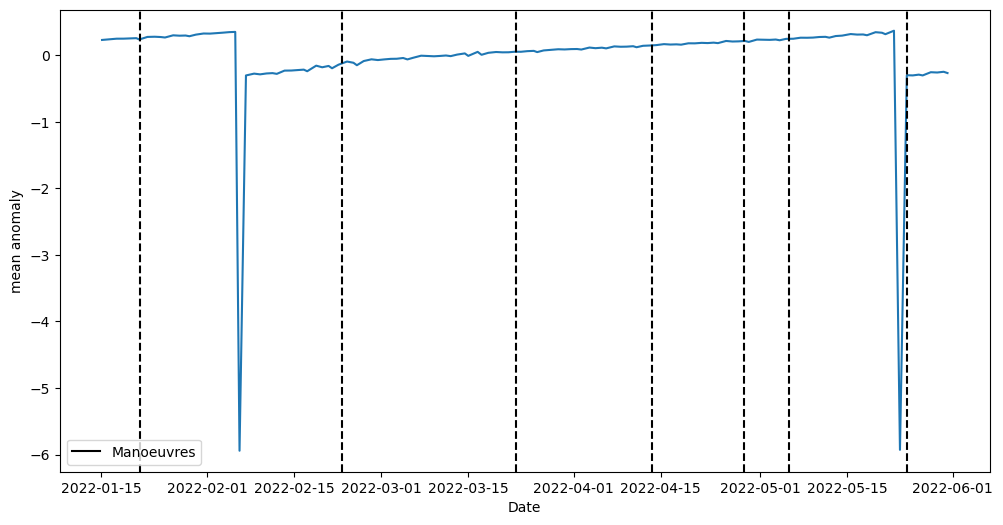

In [62]:
residuals_cs2_arima_ma = cs2_arima_results['mean anomaly'][0].resid
start =  '2022-01-15'
end = '2022-06-01'

arima_resid_plot(residuals_cs2_arima_ma, start, end, man_cs2, 'mean anomaly')

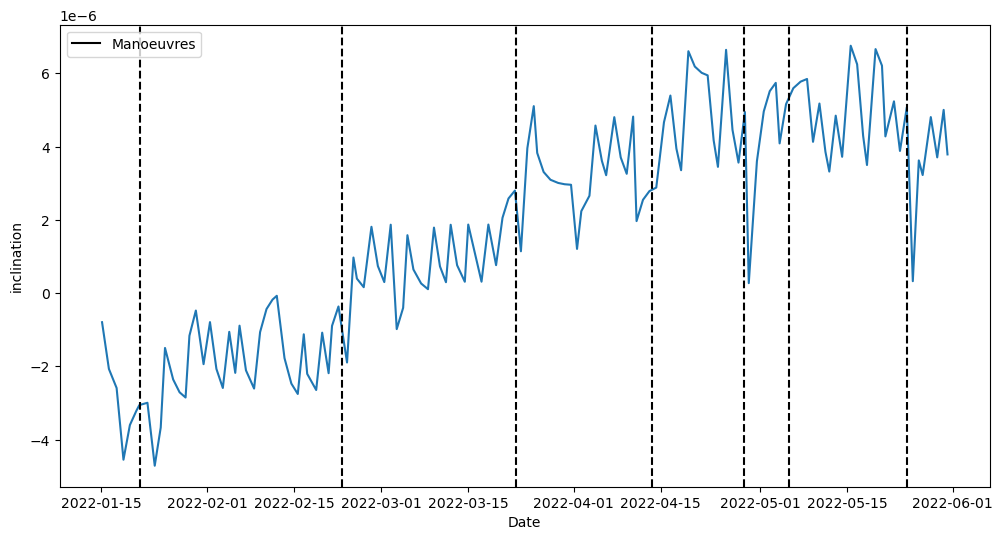

In [63]:
residuals_cs2_arima_inc = cs2_arima_results['inclination'][0].resid
start =  '2022-01-15'
end = '2022-06-01'

arima_resid_plot(residuals_cs2_arima_inc, start, end, man_cs2, 'inclination')

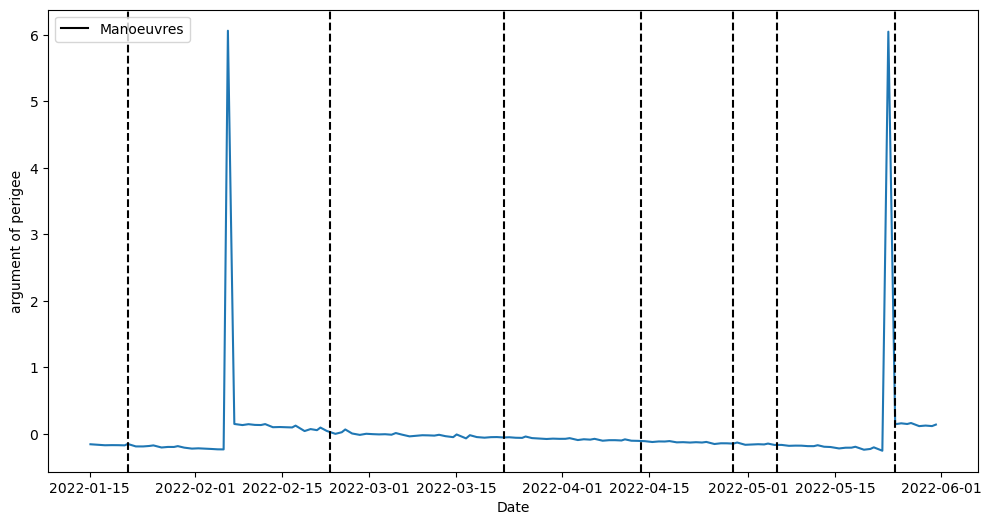

In [64]:
residuals_cs2_arima_aop = cs2_arima_results['argument of perigee'][0].resid
start =  '2022-01-15'
end = '2022-06-01'

arima_resid_plot(residuals_cs2_arima_aop, start, end, man_cs2, 'argument of perigee')

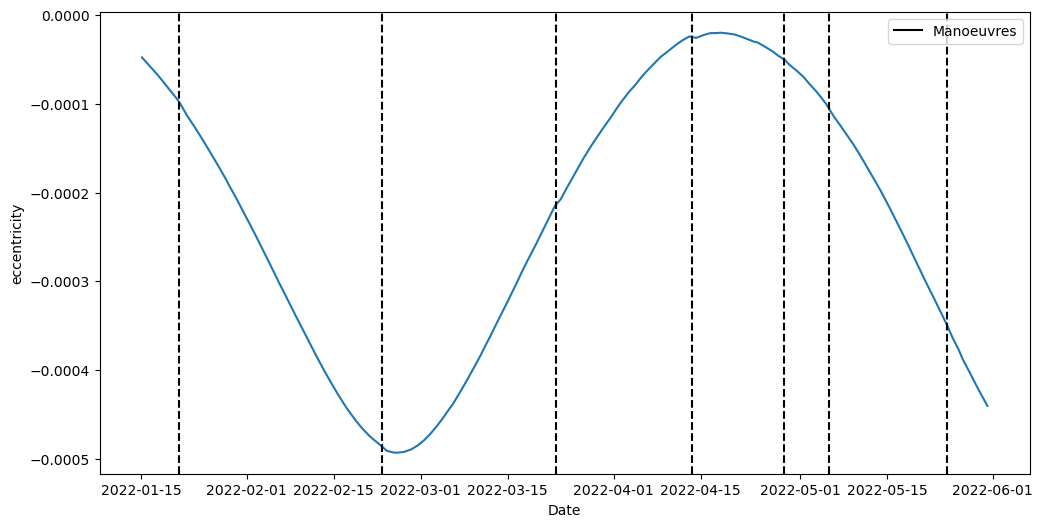

In [65]:
residuals_cs2_arima_ecc = cs2_arima_results['eccentricity'][0].resid
start =  '2022-01-15'
end = '2022-06-01'

arima_resid_plot(residuals_cs2_arima_ecc, start, end, man_cs2, 'eccentricity')

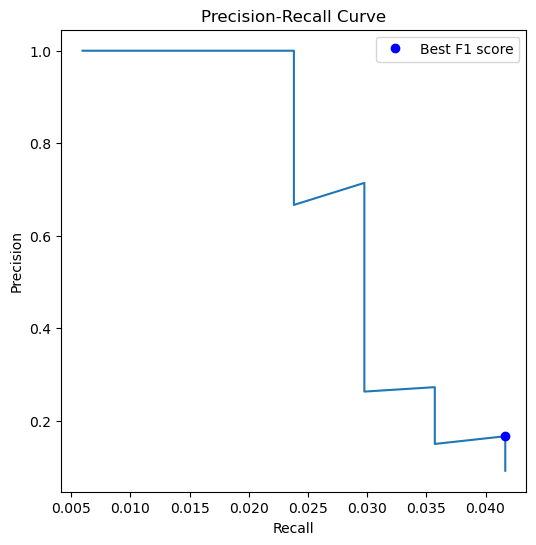

Precision : 0.16666666666666666
Recall : 0.041666666666666664
F1 Score : 0.06666666663466667


In [290]:
best_cs2_arima_model = cs2_arima_results['Brouwer mean motion'][0]
best_cs2_arima_model = best_cs2_arima_model.fittedvalues[(best_cs2_arima_model.resid.index >= '2022-01-15') & (best_cs2_arima_model.resid.index < '2022-06-01')]
precision, recall, f1score = plot_curve(man_cs2['Start Date'], best_cs2_arima_model)

print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1score}")


In [66]:
file_path_j3 = 'C:\\Users\\91701\\Documents\\y2t2\\project\\part a\\satellite_data\\orbital_elements\\unpropagated_elements_Jason-3.csv'

df_j3 = pd.read_csv(file_path_j3) 
print(df_j3.head())

                   Unnamed: 0  eccentricity  argument of perigee  inclination  \
0  2016-01-31 19:27:29.355551      0.000817             4.697711     1.152607   
1  2016-02-04 19:09:58.974336      0.000544             4.925965     1.152636   
2  2016-02-05 17:43:49.867103      0.000803             4.672899     1.152678   
3  2016-02-06 01:14:32.477856      0.000804             4.673404     1.152675   
4  2016-02-07 01:39:21.000384      0.000807             4.692616     1.152684   

   mean anomaly  Brouwer mean motion  right ascension  
0     -5.138166             0.056076         1.493000  
1     -4.924886             0.055859         1.348476  
2     -4.672712             0.055784         1.314673  
3     -4.673201             0.055784         1.303398  
4     -4.692489             0.055784         1.266706  


In [67]:
df_j3.describe()

,eccentricity,argument of perigee,inclination,mean anomaly,Brouwer mean motion,right ascension
count,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000
mean,0.000789,4.713344,1.152634,-4.713325,0.055906,3.137078
std,0.000039,0.048556,0.000029,0.049303,0.000010,1.813543
min,0.000495,4.522810,1.152570,-5.138166,0.055691,0.002424
25%,0.000767,4.676146,1.152610,-4.756978,0.055907,1.570272
50%,0.000790,4.711369,1.152636,-4.711379,0.055907,3.127959
75%,0.000813,4.757195,1.152654,-4.675909,0.055907,4.703985
max,0.001822,4.925965,1.152734,-4.521766,0.056076,6.283009


In [68]:
# Manoeuvre for Jason 3

file_path_man_j3 = 'C:\\Users\\91701\\Documents\\y2t2\\project\\part a\\satellite_data\\manoeuvres\\ja3man.txt'
data = parse_file(file_path_man_j3)

man_j3 = pd.DataFrame(data)
print(man_j3)


            Start Date            End Date
0  2016-01-19 22:18:00 2016-01-20 01:06:00
1  2016-01-21 22:39:00 2016-01-22 01:28:00
2  2016-01-28 22:45:00 2016-01-29 02:05:00
3  2016-01-31 21:38:00 2016-02-01 00:32:00
4  2016-02-02 03:35:00 2016-02-02 06:30:00
5  2016-02-03 20:53:00 2016-02-03 23:46:00
6  2016-02-04 21:04:00 2016-02-04 23:54:00
7  2016-02-07 22:35:00 2016-02-08 01:31:00
8  2016-02-09 23:25:00 2016-02-10 02:14:00
9  2016-02-11 22:19:00 2016-02-12 01:08:00
10 2016-02-23 02:46:00 2016-02-23 02:46:00
11 2016-04-04 01:49:00 2016-04-04 01:49:00
12 2016-05-19 20:02:00 2016-05-19 20:02:00
13 2016-07-25 02:50:00 2016-07-25 02:50:00
14 2016-09-14 20:52:00 2016-09-14 20:52:00
15 2016-12-22 21:13:00 2016-12-22 21:13:00
16 2017-04-12 23:41:00 2017-04-12 23:42:00
17 2017-09-06 16:34:00 2017-09-06 16:34:00
18 2017-12-12 19:36:00 2017-12-12 19:36:00
19 2018-04-04 00:21:00 2018-04-04 00:21:00
20 2018-08-19 17:35:00 2018-08-19 17:35:00
21 2018-12-18 17:59:00 2018-12-18 17:59:00
22 2019-04-

In [69]:
warnings.filterwarnings("ignore")
df_j3.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)

df_j3['datetime'] = pd.to_datetime(df_j3['datetime'])
df_j3.set_index('datetime', inplace=True)


In [70]:
warnings.filterwarnings("ignore")
df_j3 = df_j3.apply(pd.to_numeric, errors='coerce')

df_j3.dropna(inplace=True)

j3_arima_results = {}
for column in df_j3.columns:
    j3_arima_results[column] = apply_arima(df_j3[column])

In [71]:
# Display a summary for each column's ARIMA model
for column, result in j3_arima_results.items():
    print(f"ARIMA model summary for {column}:")
    print(result[0].summary())
    print("\n")

ARIMA model summary for eccentricity:
                               SARIMAX Results                                
Dep. Variable:           eccentricity   No. Observations:                 2410
Model:                 ARIMA(3, 0, 2)   Log Likelihood               17499.599
Date:                Fri, 22 Nov 2024   AIC                         -34985.199
Time:                        19:46:22   BIC                         -34944.687
Sample:                             0   HQIC                        -34970.464
                               - 2410                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008   5.45e-07   1439.430      0.000       0.001       0.001
ar.L1          0.0002      0.000      0.608      0.543      -0.000       0.001
ar.L2         

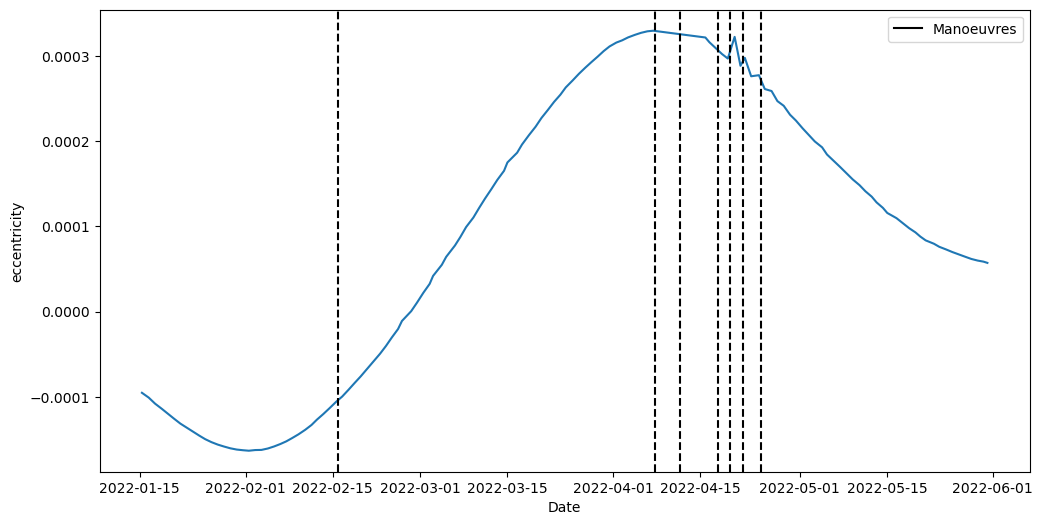

In [72]:
residuals_j3_arima_ecc = j3_arima_results['eccentricity'][0].resid
start =  '2022-01-15'
end = '2022-06-01'

arima_resid_plot(residuals_j3_arima_ecc, start, end, man_j3, 'eccentricity')

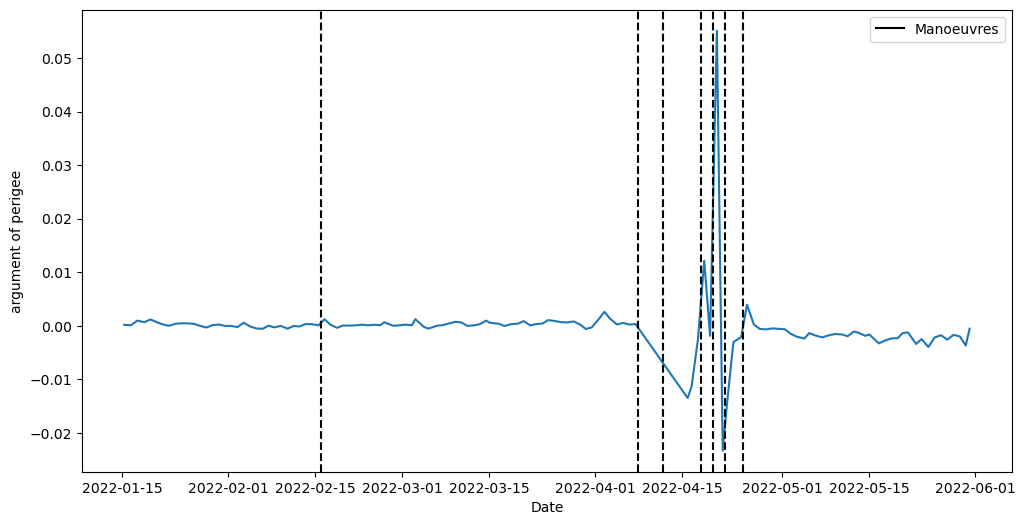

In [73]:
residuals_j3_arima_aop = j3_arima_results['argument of perigee'][0].resid
start =  '2022-01-15'
end = '2022-06-01'

arima_resid_plot(residuals_j3_arima_aop, start, end, man_j3, 'argument of perigee')

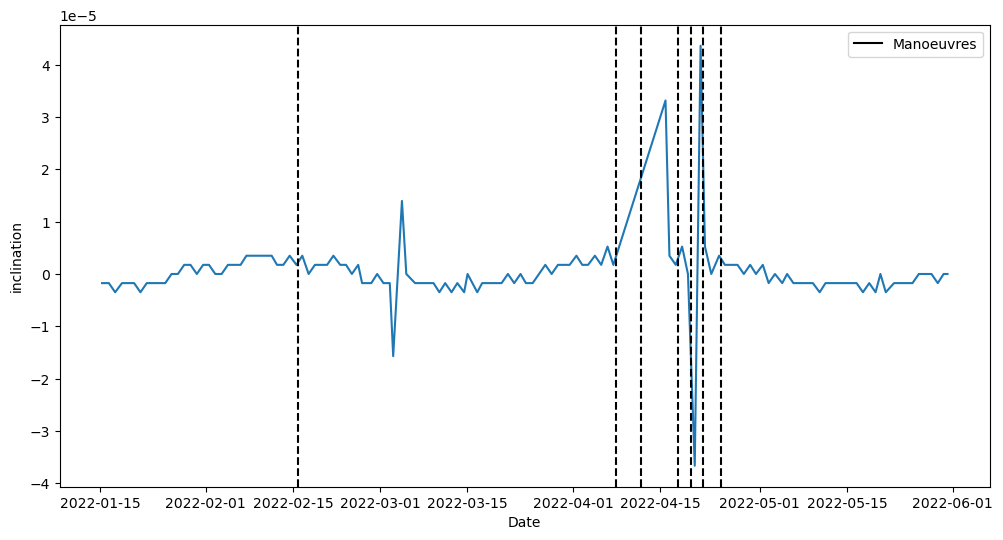

In [74]:
residuals_j3_arima_inc = j3_arima_results['inclination'][0].resid
start =  '2022-01-15'
end = '2022-06-01'

arima_resid_plot(residuals_j3_arima_inc, start, end, man_j3, 'inclination')

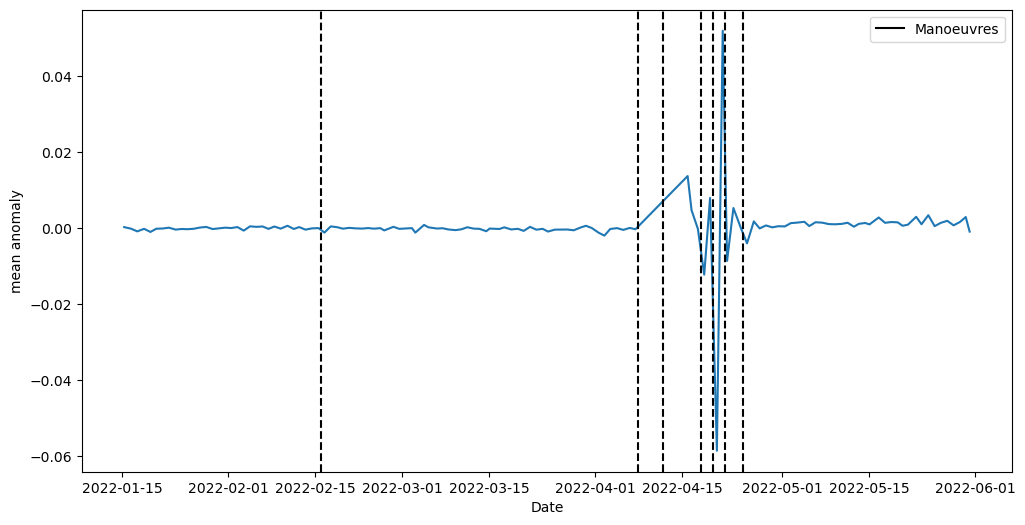

In [75]:
residuals_j3_arima_ma = j3_arima_results['mean anomaly'][0].resid
start =  '2022-01-15'
end = '2022-06-01'

arima_resid_plot(residuals_j3_arima_ma, start, end, man_j3, 'mean anomaly')

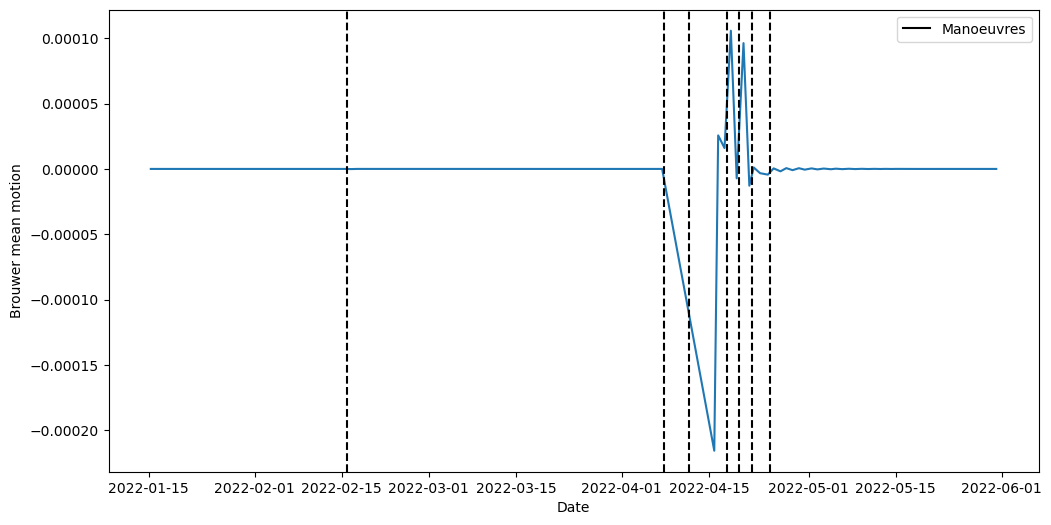

In [76]:
residuals_j3_arima_bmm = j3_arima_results['Brouwer mean motion'][0].resid
start =  '2022-01-15'
end = '2022-06-01'

arima_resid_plot(residuals_j3_arima_bmm, start, end, man_j3, 'Brouwer mean motion')

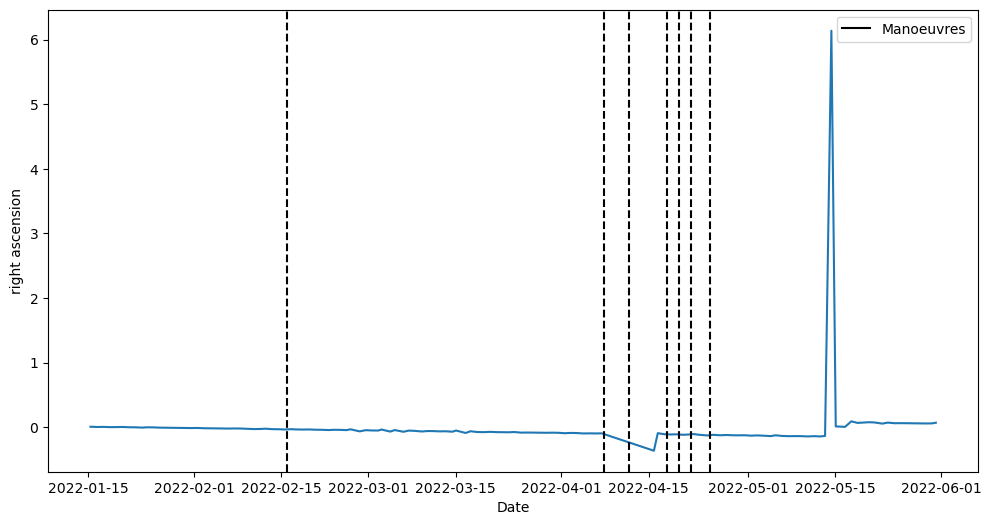

In [77]:
residuals_j3_arima_ra = j3_arima_results['right ascension'][0].resid
start =  '2022-01-15'
end = '2022-06-01'

arima_resid_plot(residuals_j3_arima_ra, start, end, man_j3, 'right ascension')

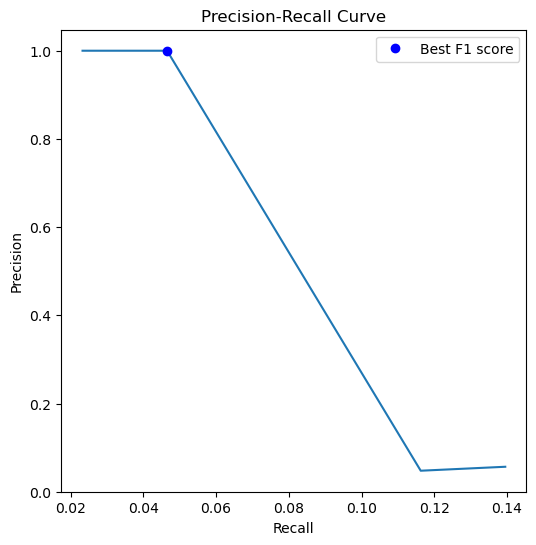

Precision : 1.0
Recall : 0.046511627906976744
F1 Score : 0.08888888888039505


In [295]:
best_j3_arima_model = j3_arima_results['Brouwer mean motion'][0]
best_j3_arima_model = best_j3_arima_model.fittedvalues[(best_j3_arima_model.resid.index >= '2022-01-15') & (best_j3_arima_model.resid.index < '2022-06-01')]
precision, recall, f1score = plot_curve(man_j3['Start Date'], best_j3_arima_model)

print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1score}")

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [128]:
def plot_acf_pacf(data):
  plot, axes = plt.subplots(nrows = 6, ncols = 2, figsize = (10, 12))

  for i, col in enumerate(data.columns):
    plot_acf(data[col], ax = axes[i, 0], title = f'ACF of {col}', lags = 20)
    plot_pacf(data[col], ax = axes[i, 1], title = f'PACF of {col}', lags = 20)

  plt.tight_layout()
  plt.show()

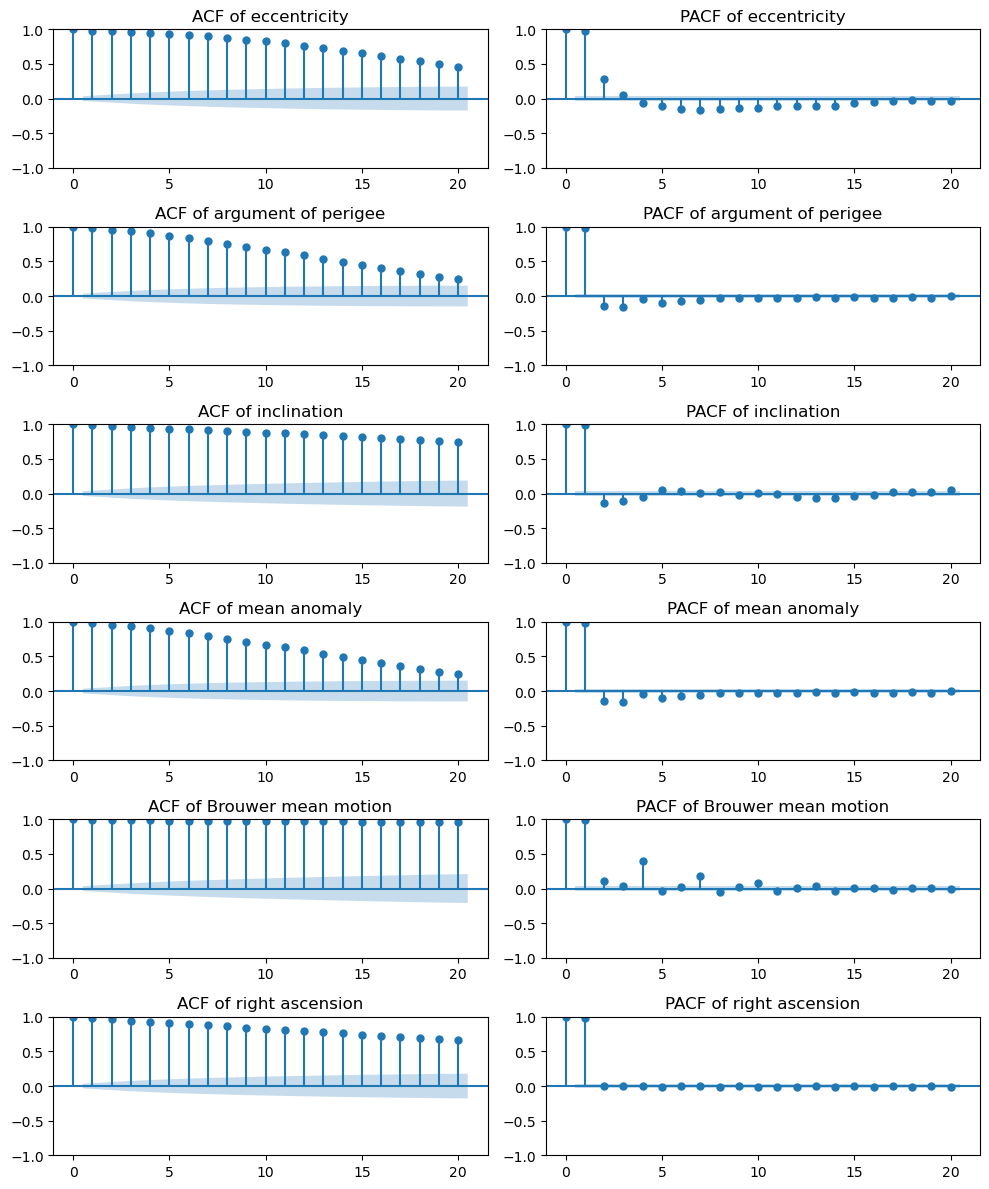

In [130]:
plot_acf_pacf(df_saral)

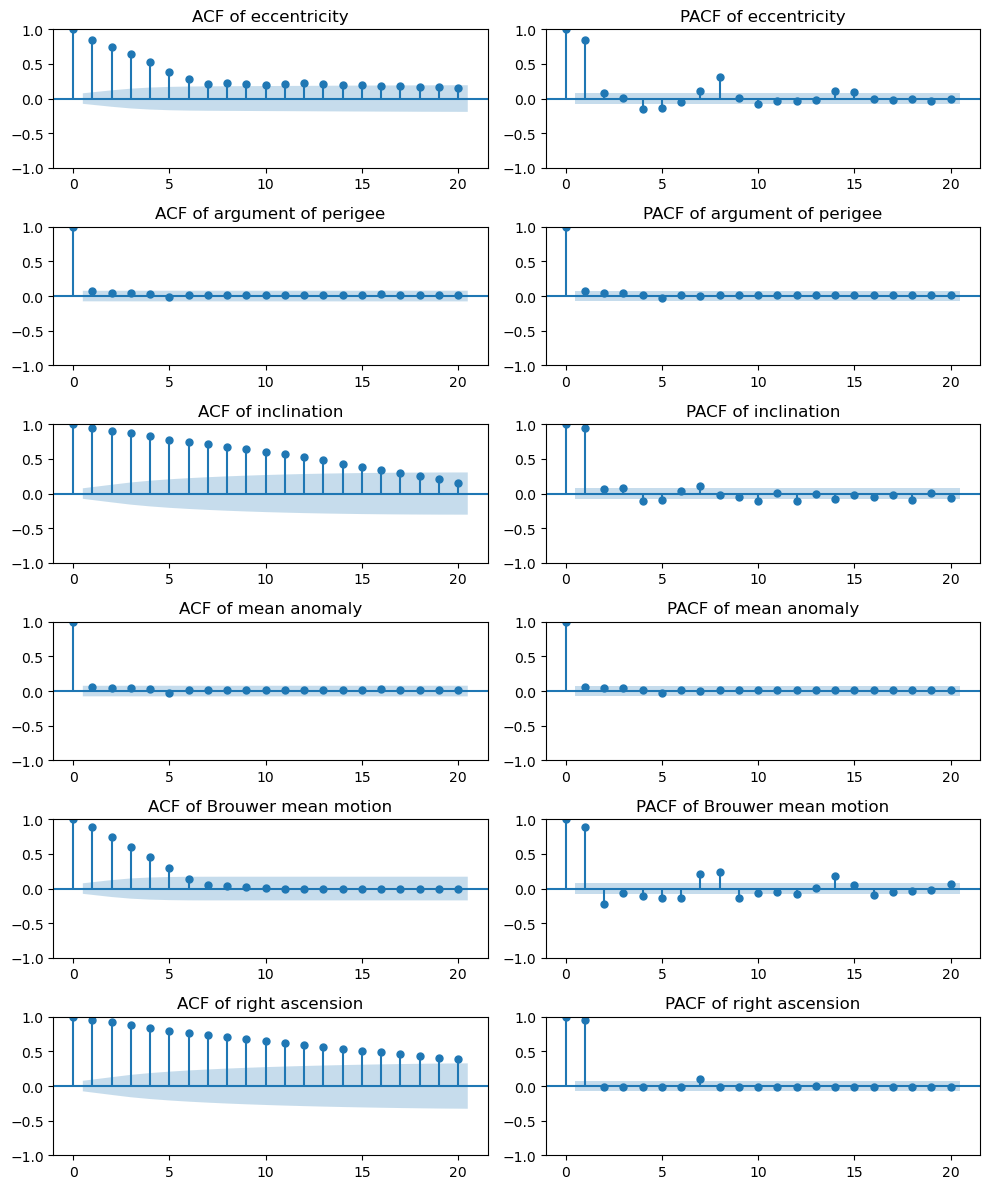

In [131]:
plot_acf_pacf(df_s6a)

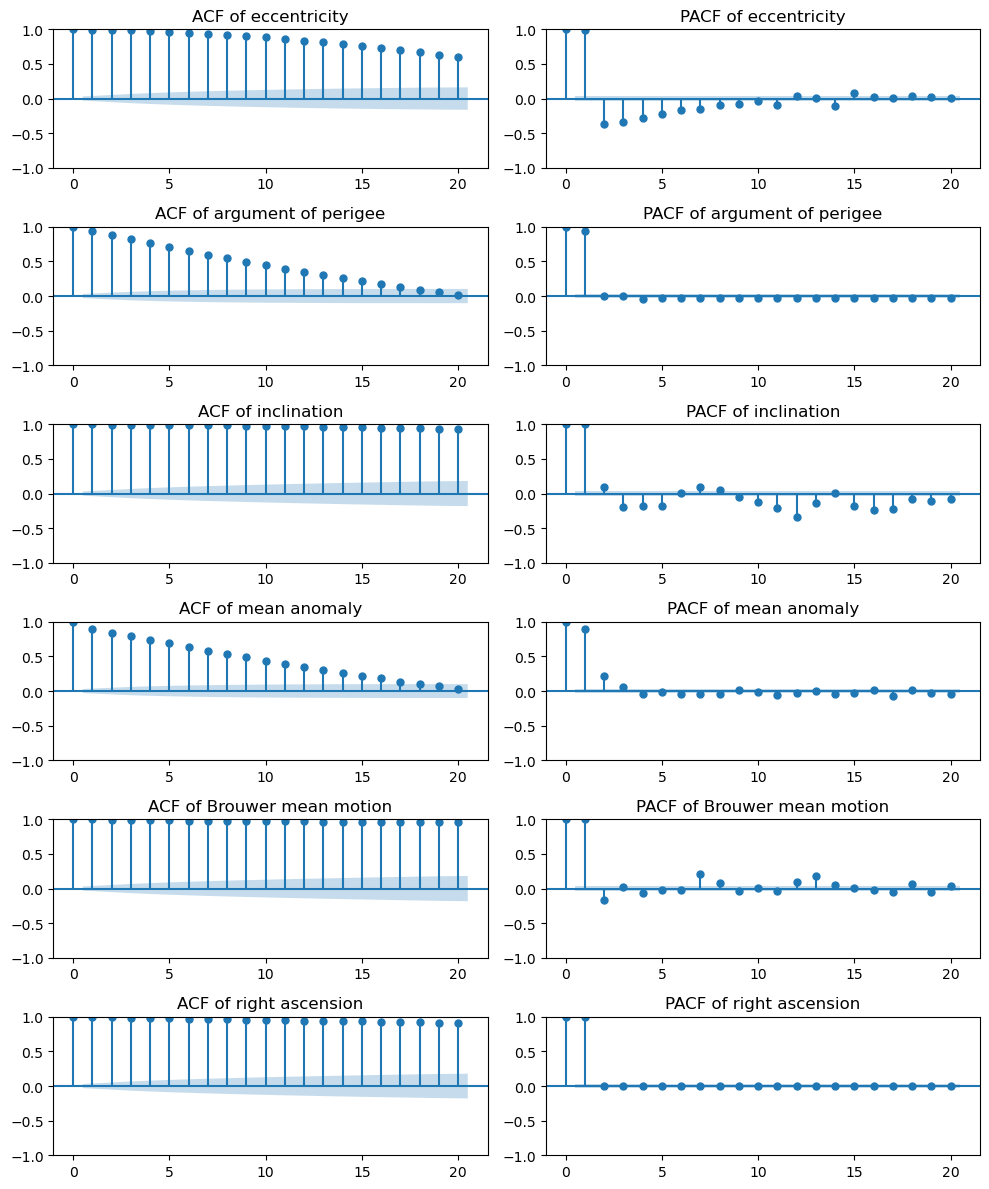

In [132]:
plot_acf_pacf(df_cs2)

In [139]:
# ADF Test function
def adf_test(series):
    result = adfuller(series)
    if result[1] <= 0.05:
        return False
    else:
        return True

def find_d(series):
    d = 0
    while adf_test(series):
        series = series.diff().dropna()  
        d += 1
    return d

def adf_series(data):
    for col in data.columns:
        d = find_d(data[col])
        print("Value of d for ", col, " is ", d)

In [140]:
adf_series(df_saral)

Value of d for  eccentricity  is  0
Value of d for  argument of perigee  is  0
Value of d for  inclination  is  0
Value of d for  mean anomaly  is  0
Value of d for  Brouwer mean motion  is  1
Value of d for  right ascension  is  0


In [141]:
adf_series(df_s6a)

Value of d for  eccentricity  is  0
Value of d for  argument of perigee  is  0
Value of d for  inclination  is  0
Value of d for  mean anomaly  is  0
Value of d for  Brouwer mean motion  is  0
Value of d for  right ascension  is  0


In [142]:
adf_series(df_cs2)

Value of d for  eccentricity  is  0
Value of d for  argument of perigee  is  0
Value of d for  inclination  is  0
Value of d for  mean anomaly  is  0
Value of d for  Brouwer mean motion  is  1
Value of d for  right ascension  is  0


In [147]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


scaler_saral = StandardScaler()
data_normalized_saral = scaler_saral.fit_transform(df_saral[columns])
data_normalized_saral = pd.DataFrame(data_normalized_saral, columns=columns, index = df_saral.index)

scaler_s6a = StandardScaler()
data_normalized_s6a = scaler_s6a.fit_transform(df_s6a[columns])
data_normalized_s6a = pd.DataFrame(data_normalized_s6a, columns=columns, index = df_s6a.index)

scaler_cs2 = StandardScaler()
data_normalized_cs2 = scaler_cs2.fit_transform(df_cs2[columns])
data_normalized_cs2 = pd.DataFrame(data_normalized_cs2, columns=columns, index = df_cs2.index)

scaler_j3 = StandardScaler()
data_normalized_j3 = scaler_j3.fit_transform(df_j3[columns])
data_normalized_j3 = pd.DataFrame(data_normalized_j3, columns=columns, index = df_j3.index)

In [348]:
param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.001],
        'max_depth': [3, 5, 7]
    }

def xgboost(df, column, man, start, end, lags = 3):
    data = df.copy()
    
    for i in range(1, lags + 1):
        data[f'lag{i}'] = data[column].shift(i)
        
    data.dropna(inplace = True)
    
    X = data.drop(columns = [column])
    y = data[column]  

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(objective='reg:squarederror')
    grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='neg_mean_squared_error', cv=3)
    fit = grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    residuals = pd.Series(np.abs(y_test - y_pred), index=y_test.index)
    residuals = residuals.loc[(residuals.index >= pd.Timestamp(start)) & (residuals.index < pd.Timestamp(end))]
    man = man.loc[(man['Start Date'] >= pd.Timestamp(start)) & (man['Start Date'] < pd.Timestamp(end))]
    residuals = residuals.sort_index()
    plt.figure(figsize=(12, 6))
    plt.plot(residuals.index, residuals.values, label="Residuals")
    plt.title(f"{column}")
    for start_date in man['Start Date']:
        plt.axvline(x=start_date, color = 'black', linestyle='--', label="Manoeuvre")
            
    legend_handles = [plt.plot([], [], color = 'black', label='Manoeuvre')[0]]
    plt.legend(handles=legend_handles)

    plt.tight_layout()
    plt.show()
    return y_test, y_pred
    

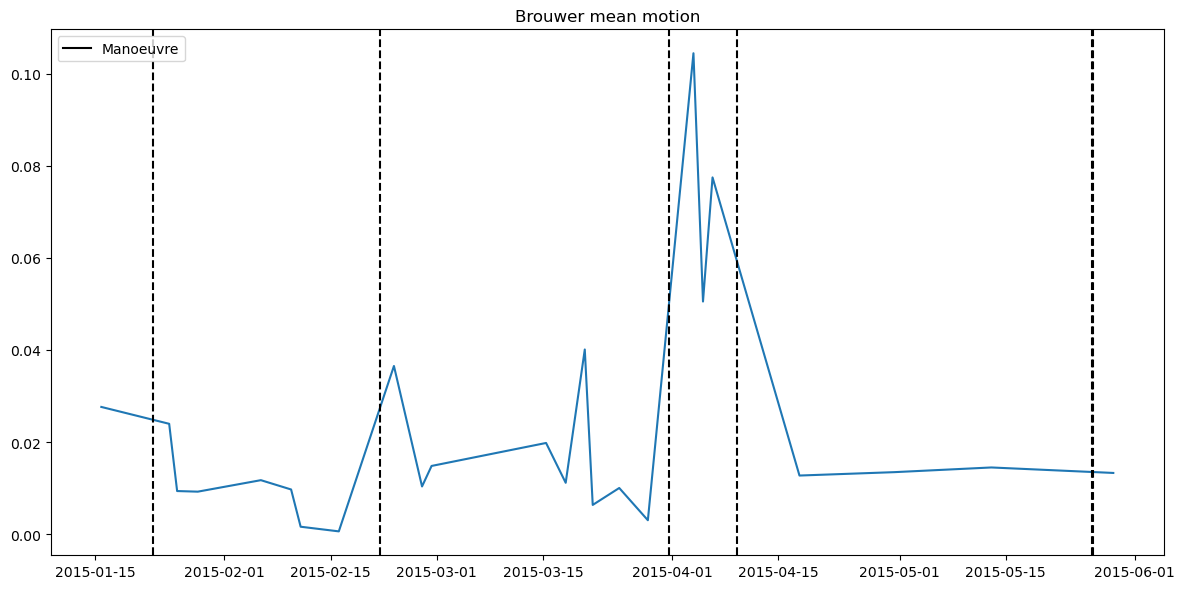

In [349]:
data = parse_file(file_path)
start =  '2015-01-15'
end = '2015-06-01'

man_saral = pd.DataFrame(data)
ind, saral_xgb_results = xgboost(data_normalized_saral, 'Brouwer mean motion', man_saral, start, end)

In [344]:
arima_results['eccentricity'][0]

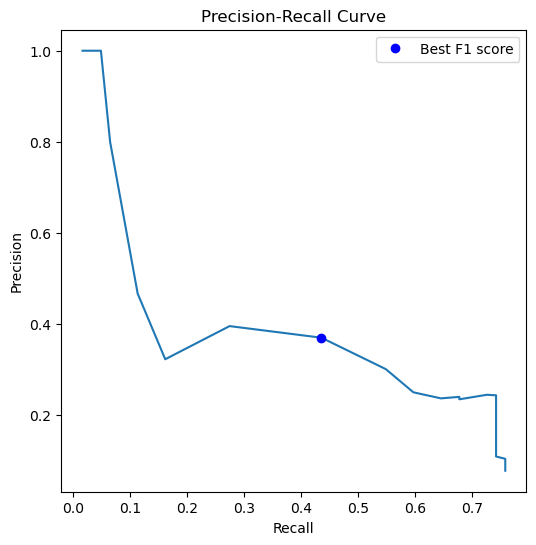

Precision : 0.3698630136986301
Recall : 0.43548387096774194
F1 Score : 0.399999999950332


In [350]:
best_saral_xgb_model = pd.Series(saral_xgb_results, index = ind.index)
precision, recall, f1score = plot_curve(man_saral['Start Date'], best_saral_xgb_model)

print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1score}")


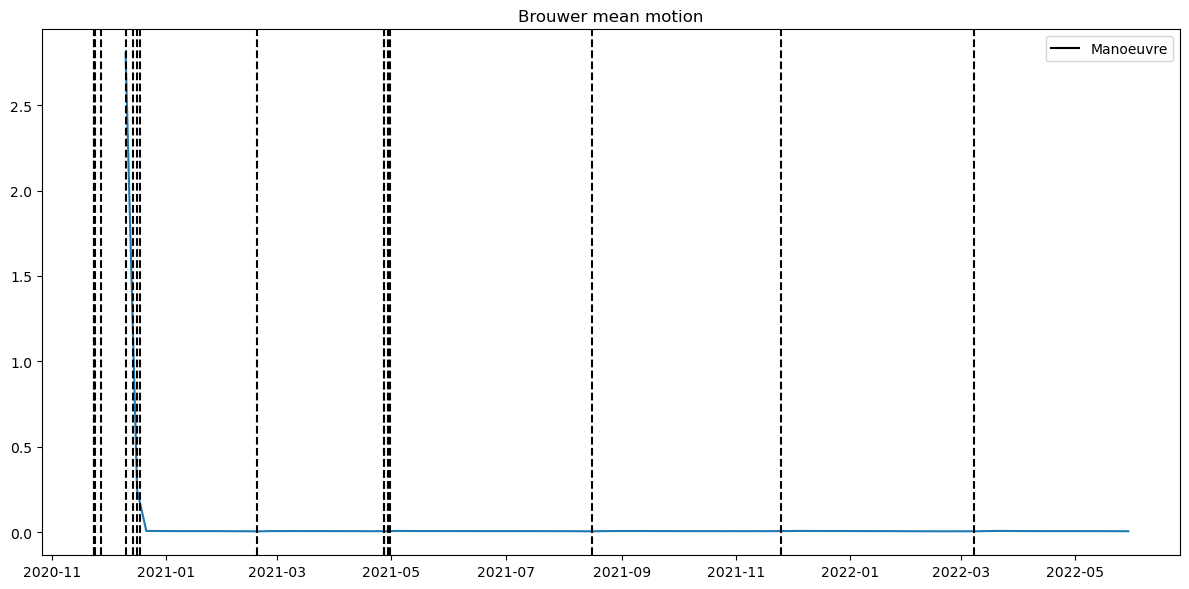

In [351]:
data = parse_file(file_path_man_s6a)
start =  '2012-01-15'
end = '2022-06-01'

man_s6a = pd.DataFrame(data)
ind, s6a_xgb_results = xgboost(data_normalized_s6a, 'Brouwer mean motion', man_s6a, start, end)

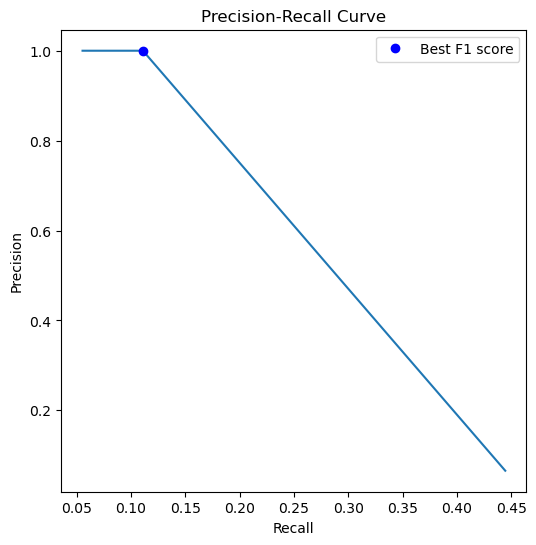

Precision : 1.0
Recall : 0.1111111111111111
F1 Score : 0.19999999998199997


In [352]:
best_s6a_xgb_model = pd.Series(s6a_xgb_results, index = ind.index)
precision, recall, f1score = plot_curve(man_s6a['Start Date'], best_s6a_xgb_model)

print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1score}")


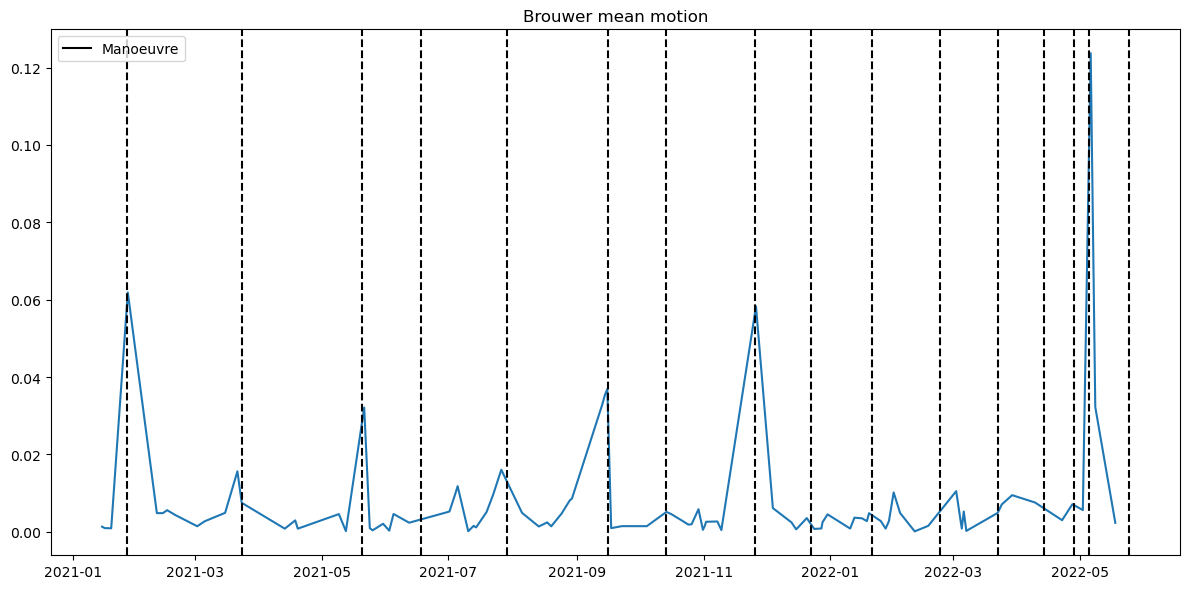

In [353]:
data = parse_file(file_path_man_cs2)
start =  '2021-01-15'
end = '2022-06-01'

man_cs2 = pd.DataFrame(data)
ind, cs2_xgb_results = xgboost(data_normalized_cs2, 'Brouwer mean motion', man_cs2, start, end)

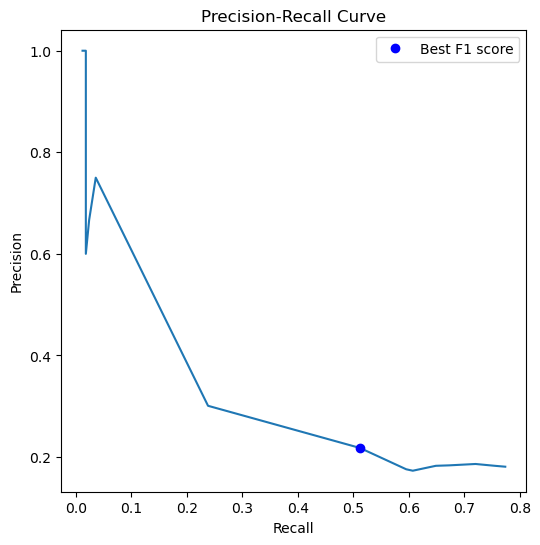

Precision : 0.21772151898734177
Recall : 0.5119047619047619
F1 Score : 0.30550621665439837


In [354]:
best_cs2_xgb_model = pd.Series(cs2_xgb_results, index = ind.index)
precision, recall, f1score = plot_curve(man_cs2['Start Date'], best_cs2_xgb_model)

print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1score}")


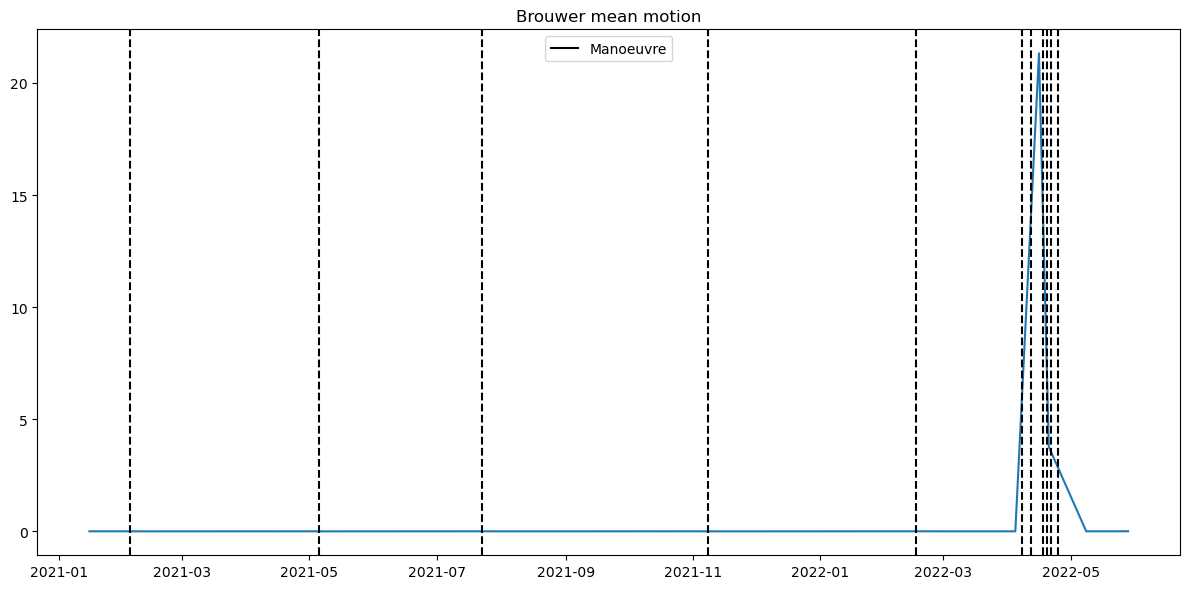

In [355]:
data = parse_file(file_path_man_j3)
start =  '2021-01-15'
end = '2022-06-01'

man_j3 = pd.DataFrame(data)
ind, j3_xgb_results = xgboost(data_normalized_j3, 'Brouwer mean motion', man_j3, start, end)

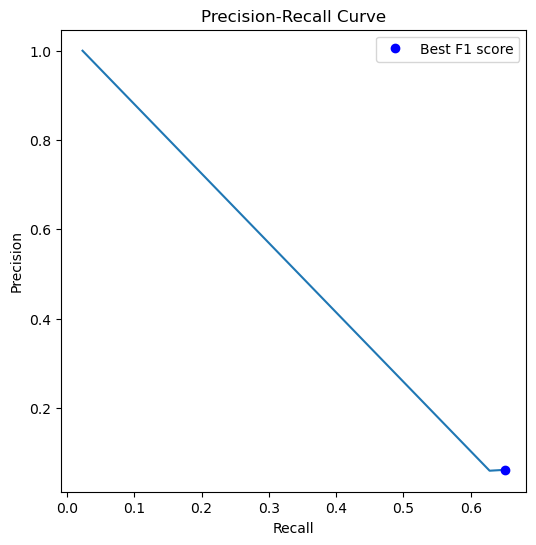

Precision : 0.061269146608315096
Recall : 0.6511627906976745
F1 Score : 0.11199999998427919


In [356]:
best_j3_xgb_model = pd.Series(j3_xgb_results, index = ind.index)
precision, recall, f1score = plot_curve(man_j3['Start Date'], best_j3_xgb_model)

print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1score}")


In [158]:
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

In [379]:
param_grid_svm = {
    "nu": [0.1, 0.2, 0.5, 0.8],
    "kernel": ["linear", "rbf", "poly", "sigmoid"],
    "gamma": ["scale", "auto"]
}

In [380]:
def custom_scorer(y_true, y_pred):
        return f1_score(y_true, y_pred, average='binary') 
    
def svm(data_normalized, data, man):
    results = {}
    pred = None
    f1_scorer = make_scorer(custom_scorer, greater_is_better=True)
    for col in columns:
        print(f"Tuning hyperparameters for {col}...")
        column = data_normalized[[col]].values
        ocsvm = OneClassSVM()
    
        grid_search = GridSearchCV(estimator = ocsvm, param_grid = param_grid_svm, scoring = f1_scorer, cv = 3)
    
        grid_search.fit(column)
    
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best Parameters for {col}: {best_params}")
        predictions = best_model.predict(column) 
        decision_function = best_model.decision_function(column)
        residuals = np.abs(decision_function)
        
        if col == "Brouwer mean motion":
            pred = predictions
            
        plt.figure(figsize=(8, 3))
        plt.plot(data_normalized.index, residuals, label='Residuals', color='blue')
        plt.title(f"Anomaly Detection: {col}")

        for start_date in man['Start Date']:
            plt.axvline(x=start_date, color = 'black', linestyle='--', label="Actual Anomalies")
            
        legend_handles = [plt.plot([], [], color = 'black', label='Manoeuvre')[0]]
        plt.legend(handles=legend_handles)  
        
    plt.tight_layout()
    plt.show()
    return pred

Tuning hyperparameters for eccentricity...
Best Parameters for eccentricity: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for argument of perigee...
Best Parameters for argument of perigee: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for inclination...
Best Parameters for inclination: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for mean anomaly...
Best Parameters for mean anomaly: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for Brouwer mean motion...
Best Parameters for Brouwer mean motion: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for right ascension...
Best Parameters for right ascension: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}


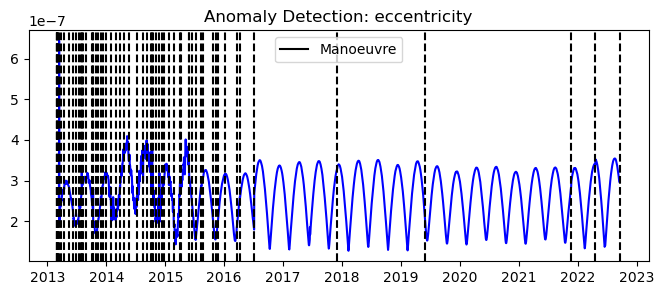

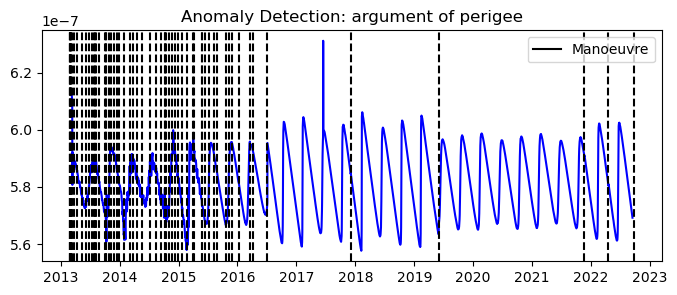

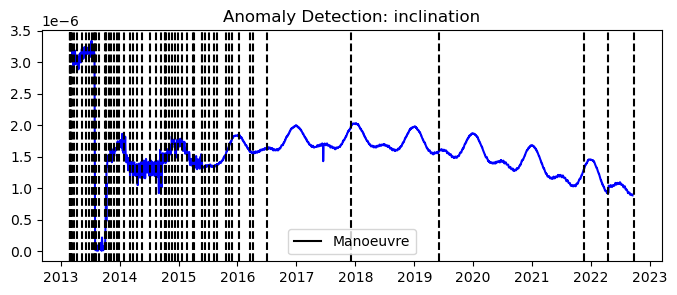

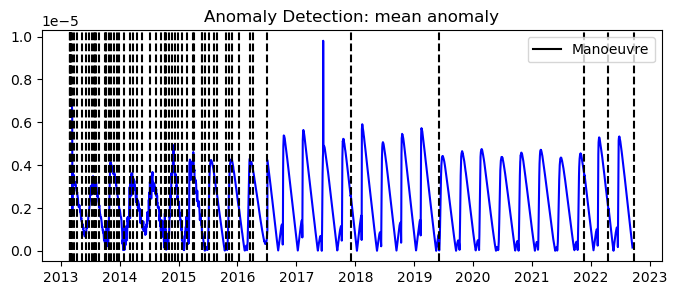

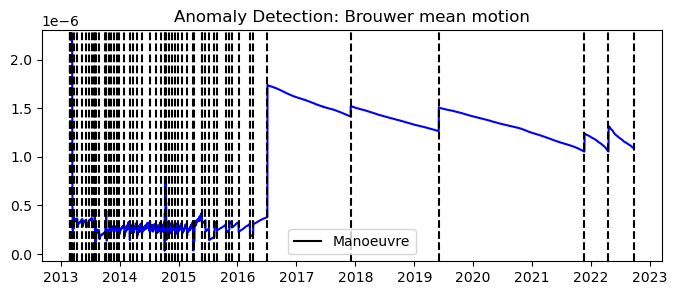

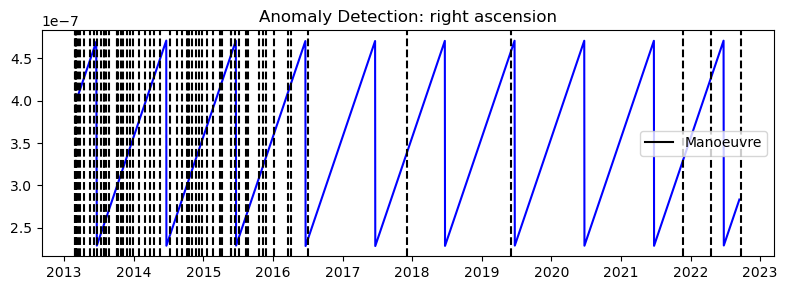

In [381]:
data = parse_file(file_path)

man_saral = pd.DataFrame(data)
pred = svm(data_normalized_saral, df_saral, man_saral)

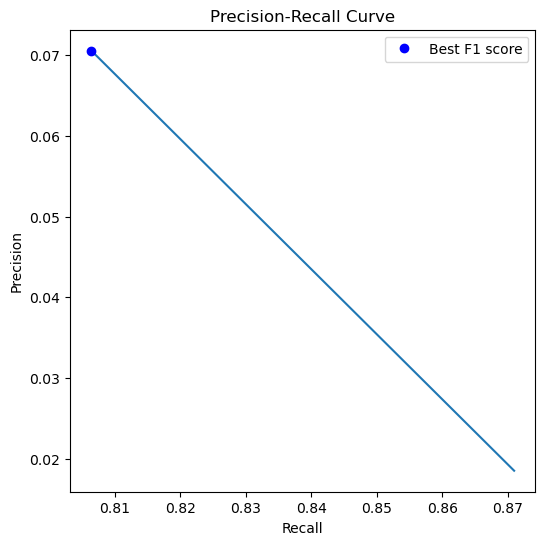

Best Precision: 0.07052186177715092
Best Recall: 0.8064516129032258
Best F1 Score: 0.1297016861071299


In [384]:
saral_svm_model = pd.Series(data=pred, index=df_saral.index)

precision, recall, f1score = plot_curve(man_saral['Start Date'], saral_svm_model)

print(f"Best Precision: {precision}")
print(f"Best Recall: {recall}")
print(f"Best F1 Score: {f1score}")


Tuning hyperparameters for eccentricity...
Best Parameters for eccentricity: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for argument of perigee...
Best Parameters for argument of perigee: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for inclination...
Best Parameters for inclination: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for mean anomaly...
Best Parameters for mean anomaly: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for Brouwer mean motion...
Best Parameters for Brouwer mean motion: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for right ascension...
Best Parameters for right ascension: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}


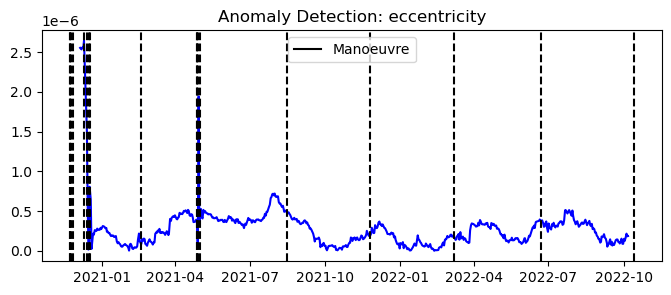

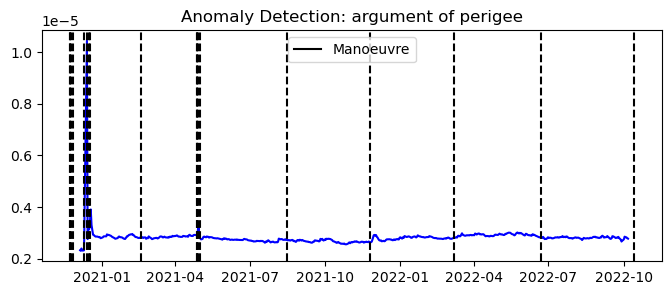

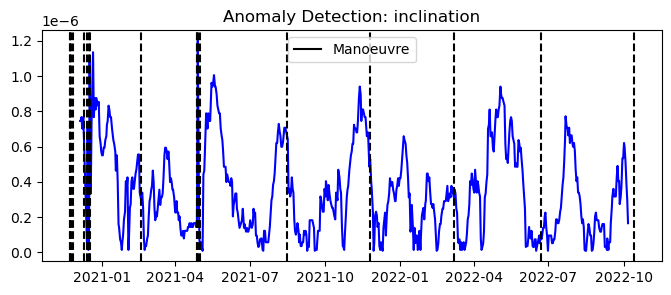

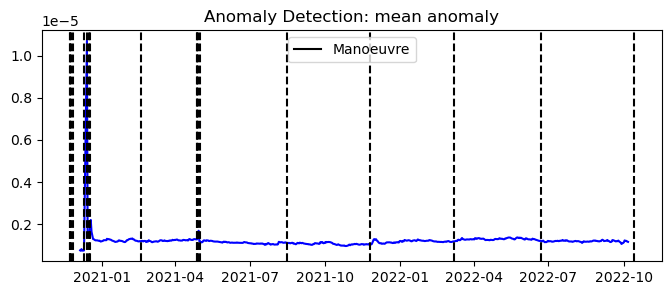

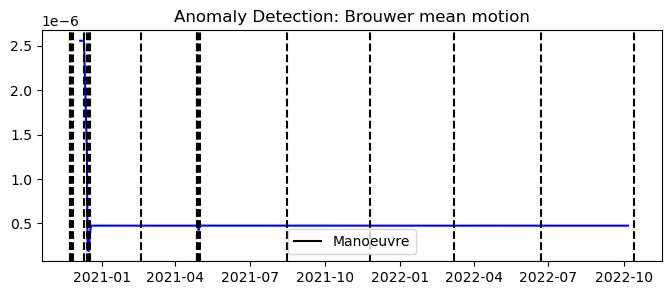

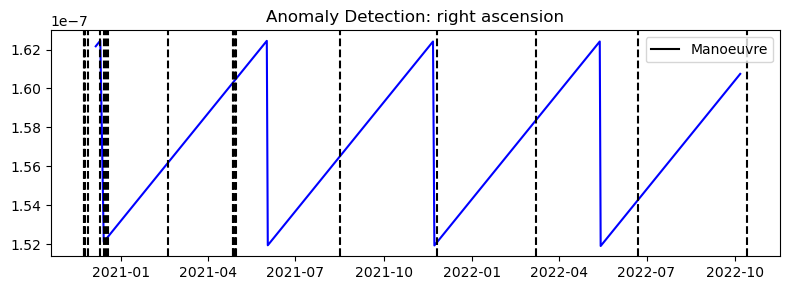

In [385]:
data = parse_file(file_path_man_s6a)
man_s6a = pd.DataFrame(data)

pred = svm(data_normalized_s6a, df_s6a, man_s6a)

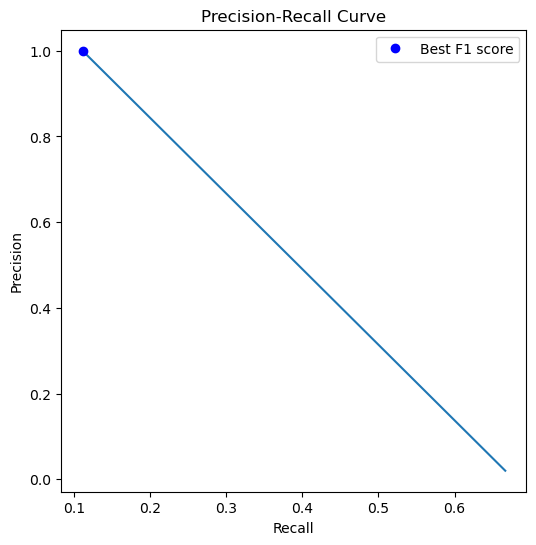

Best Precision: 1.0
Best Recall: 0.1111111111111111
Best F1 Score: 0.19999999998199997


In [386]:
s6a_svm_model = pd.Series(data=pred, index=df_s6a.index)

precision, recall, f1score = plot_curve(man_s6a['Start Date'], s6a_svm_model)

print(f"Best Precision: {precision}")
print(f"Best Recall: {recall}")
print(f"Best F1 Score: {f1score}")


Tuning hyperparameters for eccentricity...
Best Parameters for eccentricity: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for argument of perigee...
Best Parameters for argument of perigee: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for inclination...
Best Parameters for inclination: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for mean anomaly...
Best Parameters for mean anomaly: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for Brouwer mean motion...
Best Parameters for Brouwer mean motion: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for right ascension...
Best Parameters for right ascension: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}


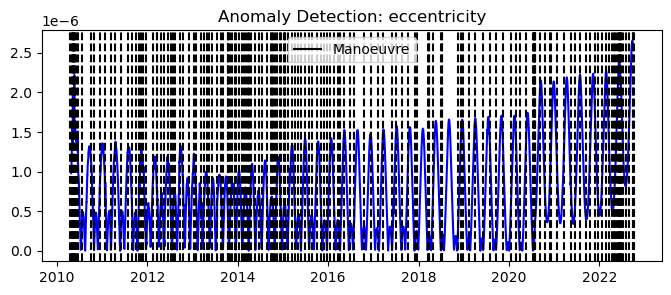

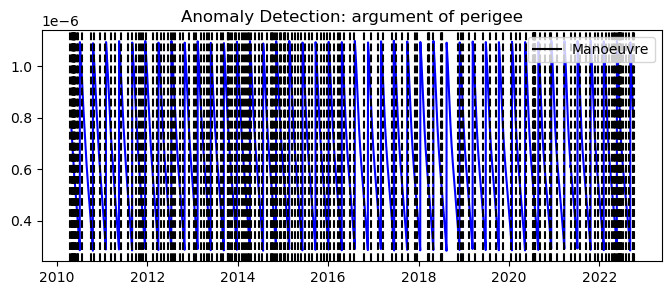

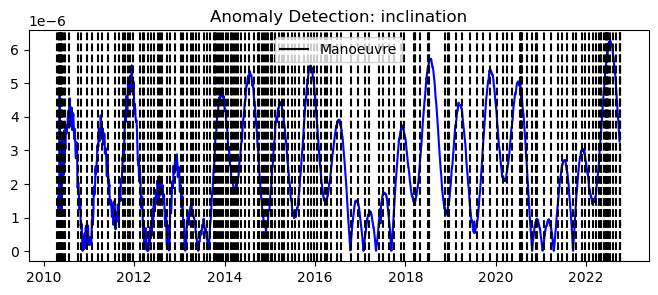

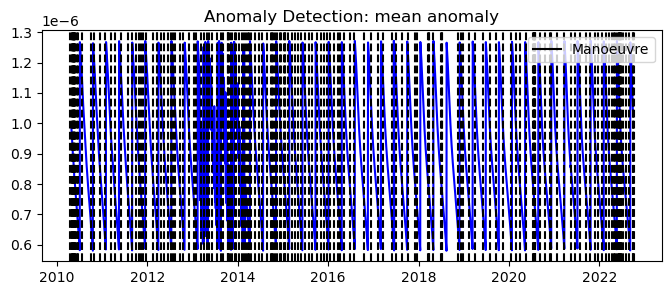

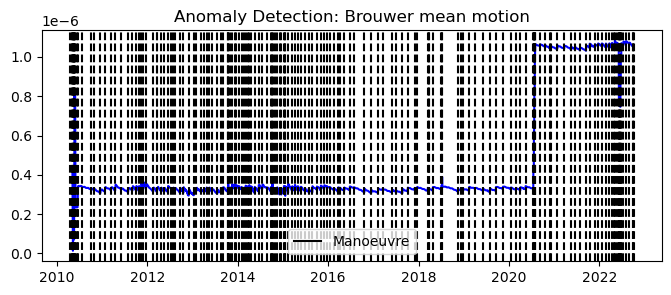

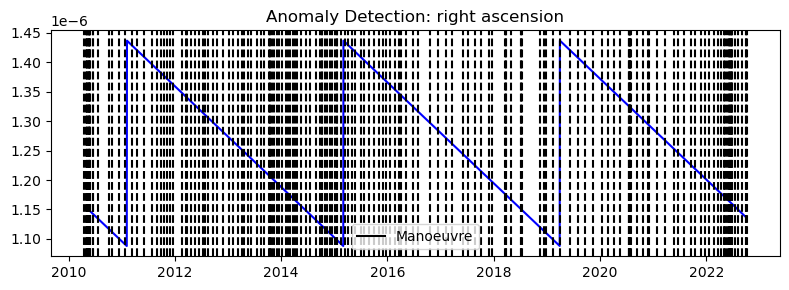

In [387]:
data = parse_file(file_path_man_cs2)

man_cs2 = pd.DataFrame(data)

pred = svm(data_normalized_cs2, df_cs2, man_cs2)

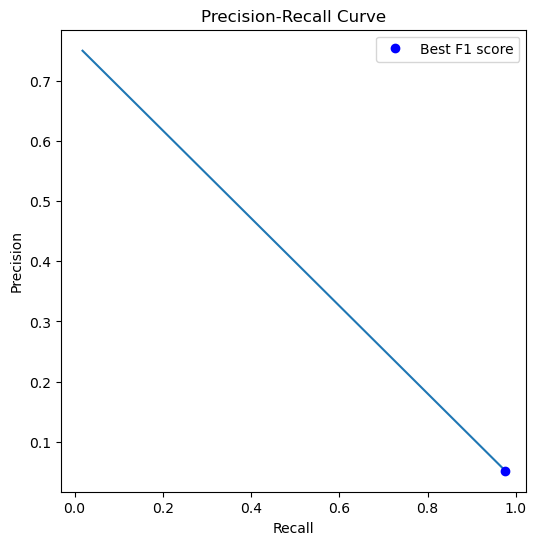

Best Precision: 0.05184950995889978
Best Recall: 0.9761904761904762
Best F1 Score: 0.09846892824019654


In [388]:
cs2_svm_model = pd.Series(data=pred, index=df_cs2.index)

precision, recall, f1score = plot_curve(man_cs2['Start Date'], cs2_svm_model)

print(f"Best Precision: {precision}")
print(f"Best Recall: {recall}")
print(f"Best F1 Score: {f1score}")


Tuning hyperparameters for eccentricity...
Best Parameters for eccentricity: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for argument of perigee...
Best Parameters for argument of perigee: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for inclination...
Best Parameters for inclination: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for mean anomaly...
Best Parameters for mean anomaly: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for Brouwer mean motion...
Best Parameters for Brouwer mean motion: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}
Tuning hyperparameters for right ascension...
Best Parameters for right ascension: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.1}


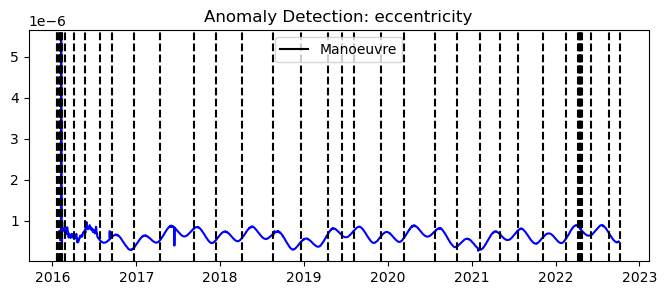

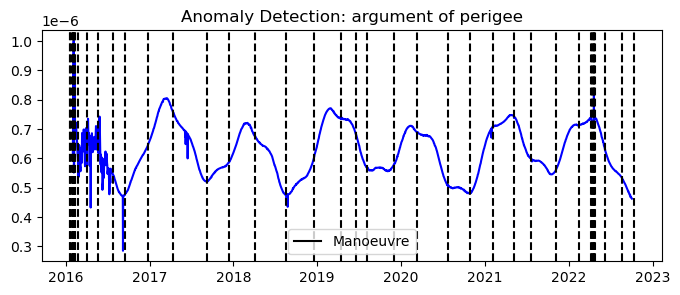

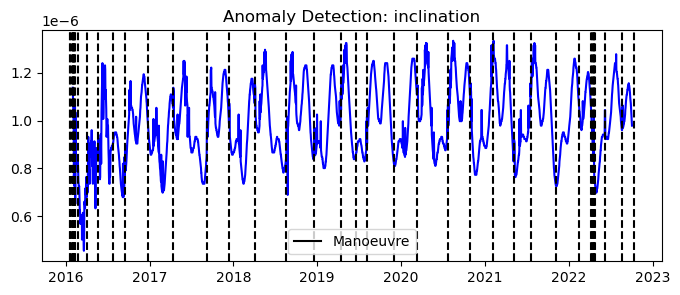

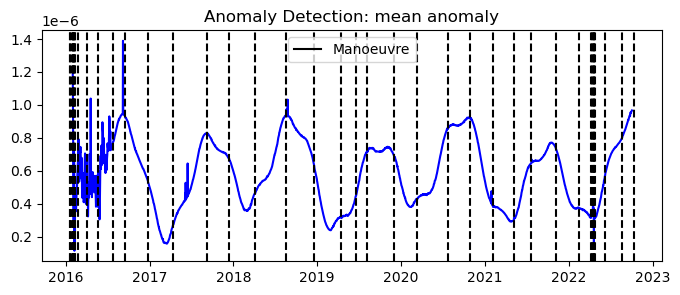

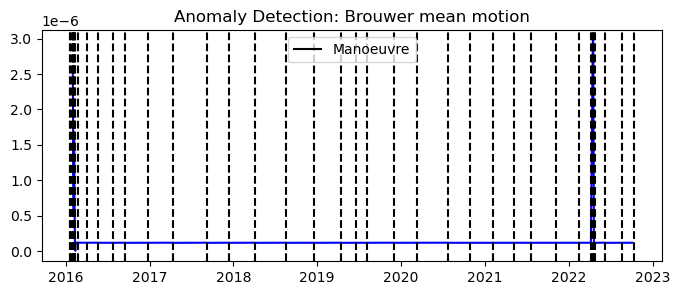

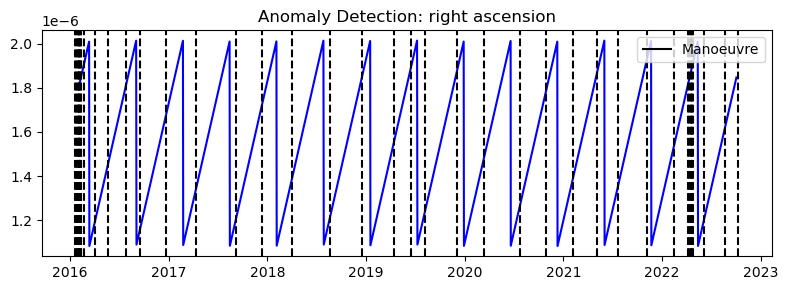

In [390]:
data = parse_file(file_path_man_j3)

man_j3 = pd.DataFrame(data)

pred = svm(data_normalized_j3, df_j3, man_j3)

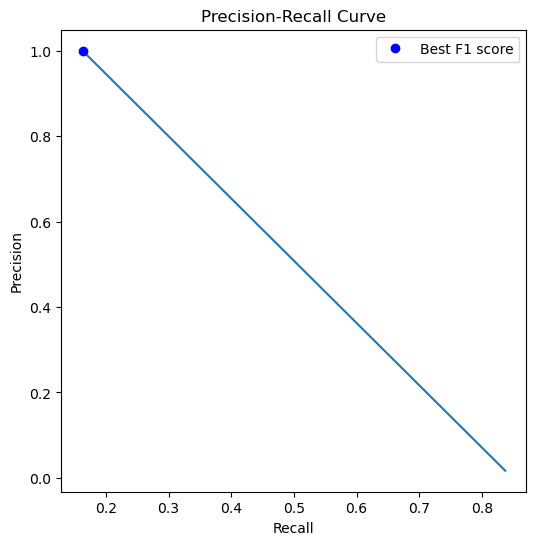

Best Precision: 1.0
Best Recall: 0.16279069767441862
Best F1 Score: 0.27999999997592


In [391]:
j3_svm_model = pd.Series(data=pred, index=df_j3.index)

precision, recall, f1score = plot_curve(man_j3['Start Date'], j3_svm_model)

print(f"Best Precision: {precision}")
print(f"Best Recall: {recall}")
print(f"Best F1 Score: {f1score}")
